___

<center><h1>Bank Churn Analysis</h1></center>

___

<center><h2>I Cloud 7</h2></center><br>
<center> Data Scientist Jr. Assessment </center>

___
<p></p>
<center style="color: #AA6373; font-weight: 400;"><strong>Presented by:</strong></center>
<center style="color: #AA6373; font-weight: 400;">Jorge Forero L.</center>

<center>September 2024</center>
<p></p>

In [28]:
# --- Common Modules ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# --- Modelling ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer

# --- Testing and Evaluation ---
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV


In [29]:
file_path = '../src/Bank+Customer+Churn/Bank_Churn.csv'

try:
    # Handling of bad lines
    df_bank_churn = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')
    print("Data loaded successfully. Displaying the first 5 rows:")
    print(df_bank_churn.head())

    print("\nColumn names:")
    print(df_bank_churn.columns)

except FileNotFoundError:
    print("Error: File not found at the specified path.")
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file. Please check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Data loaded successfully. Displaying the first 5 rows:
   CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4      

## Exploratory Data Analysis

#### Volume of Data

In [30]:
# Just to make sure the data was loaded entirely
num_records = len(df_bank_churn)
num_features = len(df_bank_churn.columns)

print(f"The dataset has {num_records} records and {num_features} features.")

The dataset has 10000 records and 13 features.


In [31]:
# Basic data exploration
print("Shape of the dataset:", df_bank_churn.shape)
print("Data types:", df_bank_churn.dtypes)
print("Missing values in each column:", df_bank_churn.isnull().sum())
df_bank_churn.describe()

Shape of the dataset: (10000, 13)
Data types: CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
Missing values in each column: CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


CustomerId   CreditScore           Age        Tenure        Balance  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean   1.569094e+07    650.528800     38.921800      5.012800   76485.889288   
std    7.193619e+04     96.653299     10.487806      2.892174   62397.405202   
min    1.556570e+07    350.000000     18.000000      0.000000       0.000000   
25%    1.562853e+07    584.000000     32.000000      3.000000       0.000000   
50%    1.569074e+07    652.000000     37.000000      5.000000   97198.540000   
75%    1.575323e+07    718.000000     44.000000      7.000000  127644.240000   
max    1.581569e+07    850.000000     92.000000     10.000000  250898.090000   

       NumOfProducts    HasCrCard  IsActiveMember  EstimatedSalary  \
count   10000.000000  10000.00000    10000.000000     10000.000000   
mean        1.530200      0.70550        0.515100    100090.239881   
std         0.581654      0.45584        0.499797     57510.492818   
min         1.000000      0.00000        0.000000        11.580000   
25%         1.000000      0.00000        0.000000     51002.110000   
50%         1.000000      1.00000        1.000000    100193.915000   
75%         2.000000      1.00000        1.000000    149388.247500   
max         4.000000      1.00000        1.000000    199992.480000   

             Exited  
count  10000.000000  
mean       0.203700  
std        0.402769  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

#### Data Cleaning

##### Fixing Data Types

In [32]:
# Change the data types of the specified columns to Boolean because of the description of each 
df_bank_churn['HasCrCard'] = df_bank_churn['HasCrCard'].astype(bool)
df_bank_churn['IsActiveMember'] = df_bank_churn['IsActiveMember'].astype(bool)

print(df_bank_churn[['HasCrCard', 'IsActiveMember']].dtypes)

HasCrCard         bool
IsActiveMember    bool
dtype: object


In [33]:
# Drop Columns that are not relevant to the analysis
columns_to_drop = ['Surname', 'Gender', 'CustomerId']

df_cleaned = df_bank_churn.drop(columns=columns_to_drop)
df_cleaned.head()

CreditScore Geography  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619    France   42       2       0.00              1       True   
1          608     Spain   41       1   83807.86              1      False   
2          502    France   42       8  159660.80              3       True   
3          699    France   39       1       0.00              2      False   
4          850     Spain   43       2  125510.82              1       True   

   IsActiveMember  EstimatedSalary  Exited  
0            True        101348.88       1  
1            True        112542.58       0  
2           False        113931.57       1  
3           False         93826.63       0  
4            True         79084.10       0

#### Categorical Feature Summary


In [34]:
# Set the count to distinct values in each categorical feature
for col_name in ['Geography', 'NumOfProducts']:
    print(f"\nDistinct counts for {col_name}:")
    print(df_cleaned[col_name].value_counts())



Distinct counts for Geography:
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Distinct counts for NumOfProducts:
NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64


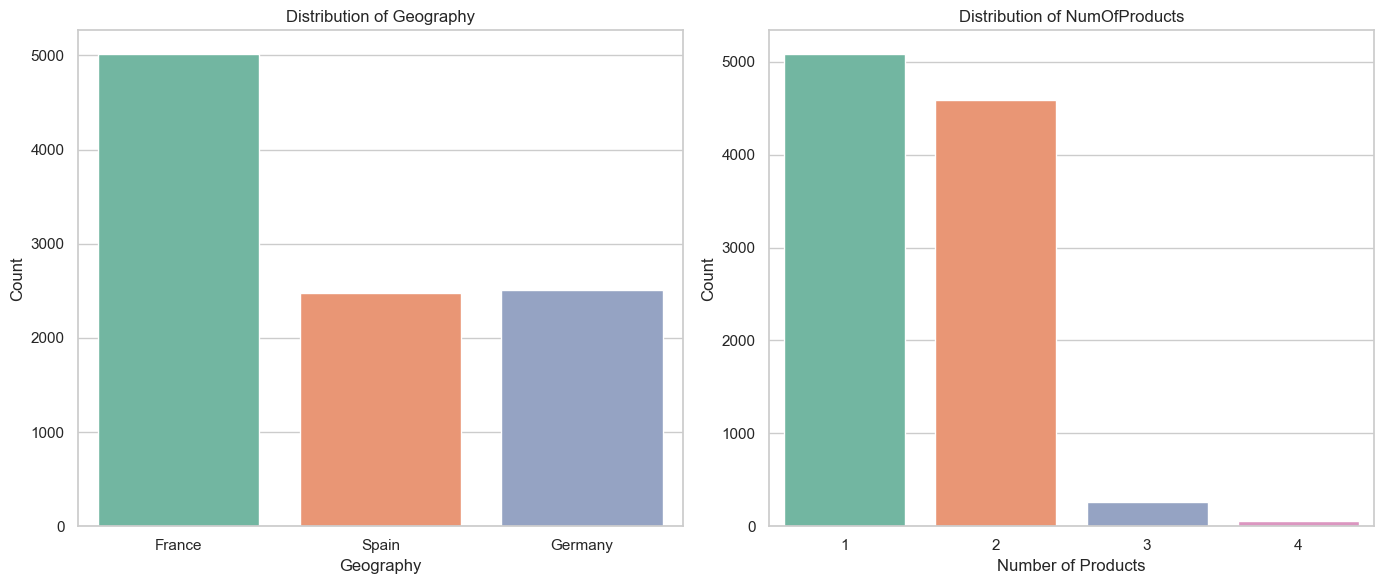

In [35]:
# Plotting the distributions
sns.set(style="whitegrid")

# Create two subplots - one for 'Geography' and one for 'NumOfProducts'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution of 'Geography'
sns.countplot(ax=axes[0], data=df_bank_churn, x='Geography', hue='Geography', palette='Set2', legend=False)
axes[0].set_title('Distribution of Geography')
axes[0].set_xlabel('Geography')
axes[0].set_ylabel('Count')

# Plot the distribution of 'NumOfProducts'
sns.countplot(ax=axes[1], data=df_bank_churn, x='NumOfProducts', hue='NumOfProducts', palette='Set2', legend=False)
axes[1].set_title('Distribution of NumOfProducts')
axes[1].set_xlabel('Number of Products')
axes[1].set_ylabel('Count')

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()

#### Regional Exploratory Data Analysis
We will be performing the analysis separating the different countries because each country might have different factors influencing customer churn (e.g., demographic, economic, or cultural differences). By separating the datasets, we can build models that better reflect these regional nuances.

In [36]:
# Dataset by countries
df_france = df_cleaned[df_bank_churn['Geography'] == 'France']
df_spain = df_cleaned[df_bank_churn['Geography'] == 'Spain']
df_germany = df_cleaned[df_bank_churn['Geography'] == 'Germany']

print("France dataset size:", df_france.shape)
print("Spain dataset size:", df_spain.shape)
print("Germany dataset size:", df_germany.shape)

France dataset size: (5014, 10)
Spain dataset size: (2477, 10)
Germany dataset size: (2509, 10)


In [37]:
# Summary Statistics per country
print("Summary statistics for France:")
print(df_france.describe())

print("Summary statistics for Spain:")
print(df_spain.describe())

print("Summary statistics for Germany:")
print(df_germany.describe())

Summary statistics for France:
       CreditScore          Age       Tenure        Balance  NumOfProducts  \
count  5014.000000  5014.000000  5014.000000    5014.000000    5014.000000   
mean    649.668329    38.511767     5.004587   62092.636516       1.530913   
std      97.016799    10.469459     2.888475   64133.565524       0.570347   
min     350.000000    18.000000     0.000000       0.000000       1.000000   
25%     582.000000    31.000000     2.000000       0.000000       1.000000   
50%     653.000000    37.000000     5.000000   62153.500000       1.000000   
75%     717.000000    43.000000     7.000000  121444.877500       2.000000   
max     850.000000    92.000000    10.000000  238387.560000       4.000000   

       EstimatedSalary       Exited  
count      5014.000000  5014.000000  
mean      99899.180814     0.161548  
std       57336.289016     0.368072  
min          90.070000     0.000000  
25%       51399.190000     0.000000  
50%       99132.310000     0.000000  


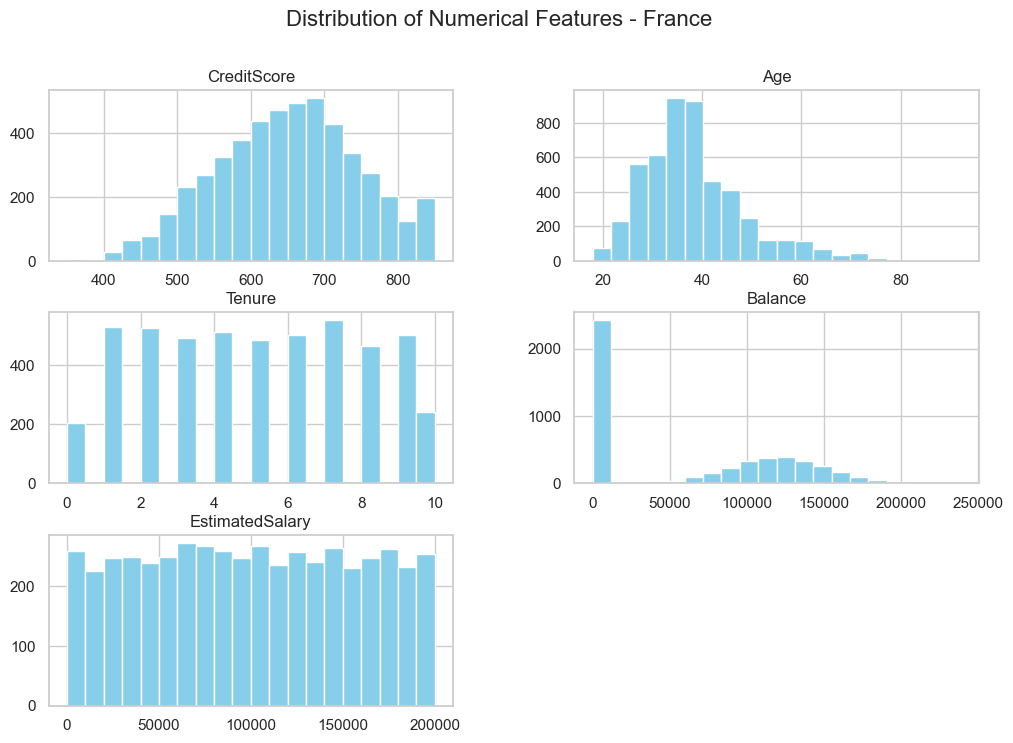

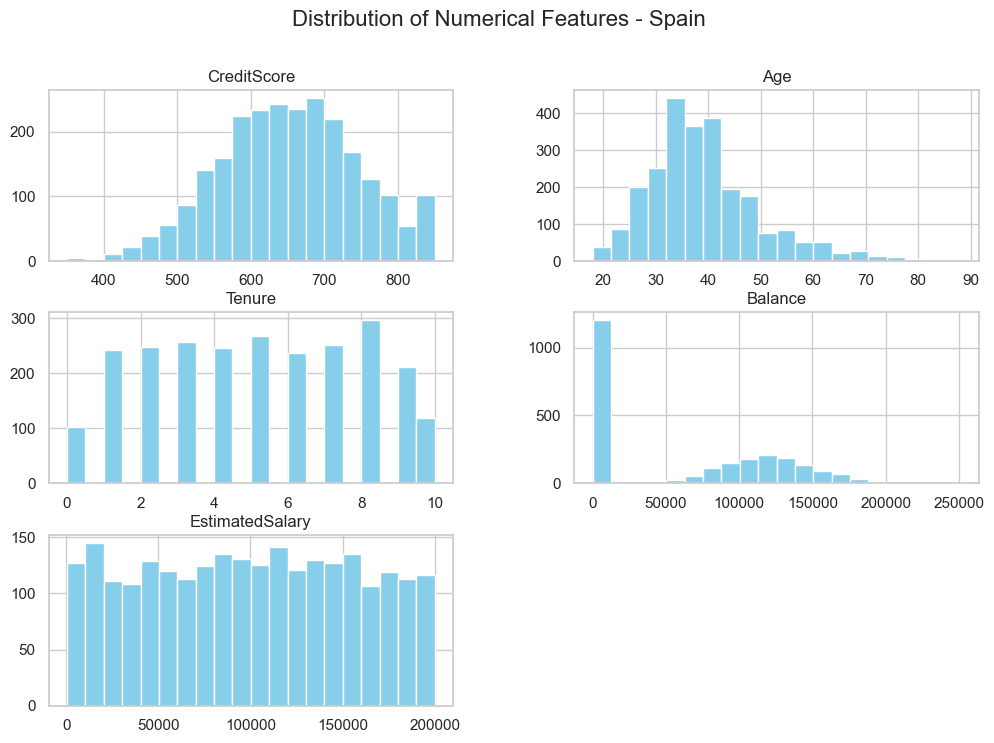

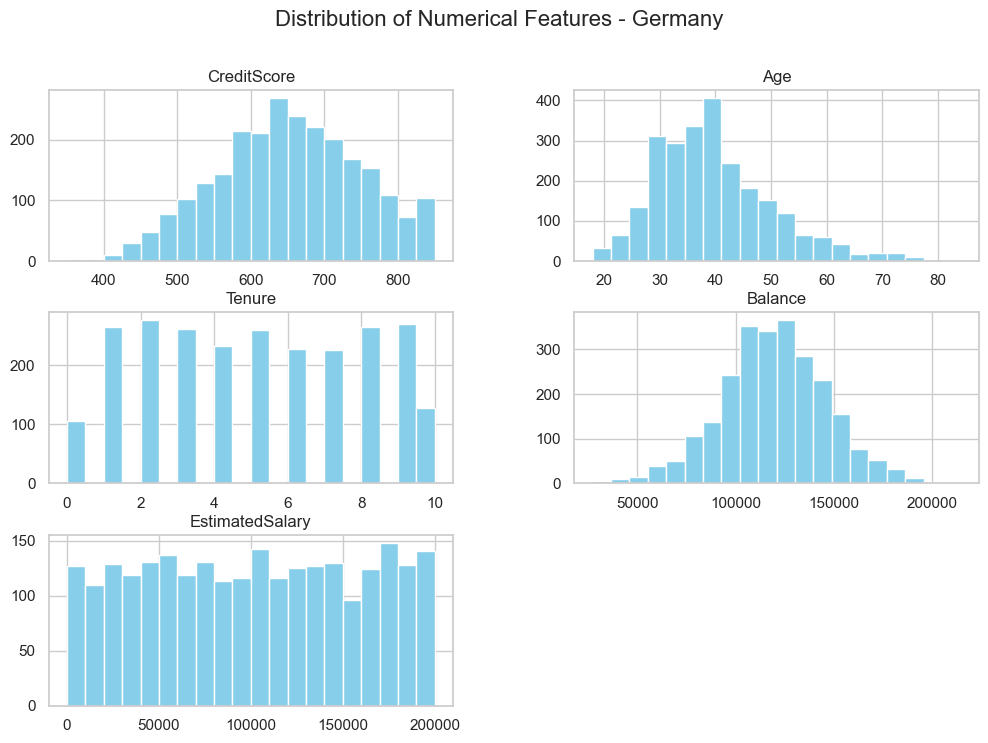

In [38]:
# Distribution of Numerical Features

# Function to plot histograms for numerical features
def plot_numerical_distribution(df, country_name):
    numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

    df[numerical_features].hist(bins=20, figsize=(12, 8), color='skyblue')
    plt.suptitle(f"Distribution of Numerical Features - {country_name}", fontsize=16)
    plt.show()

# Plot for each country
plot_numerical_distribution(df_france, "France")
plot_numerical_distribution(df_spain, "Spain")
plot_numerical_distribution(df_germany, "Germany")

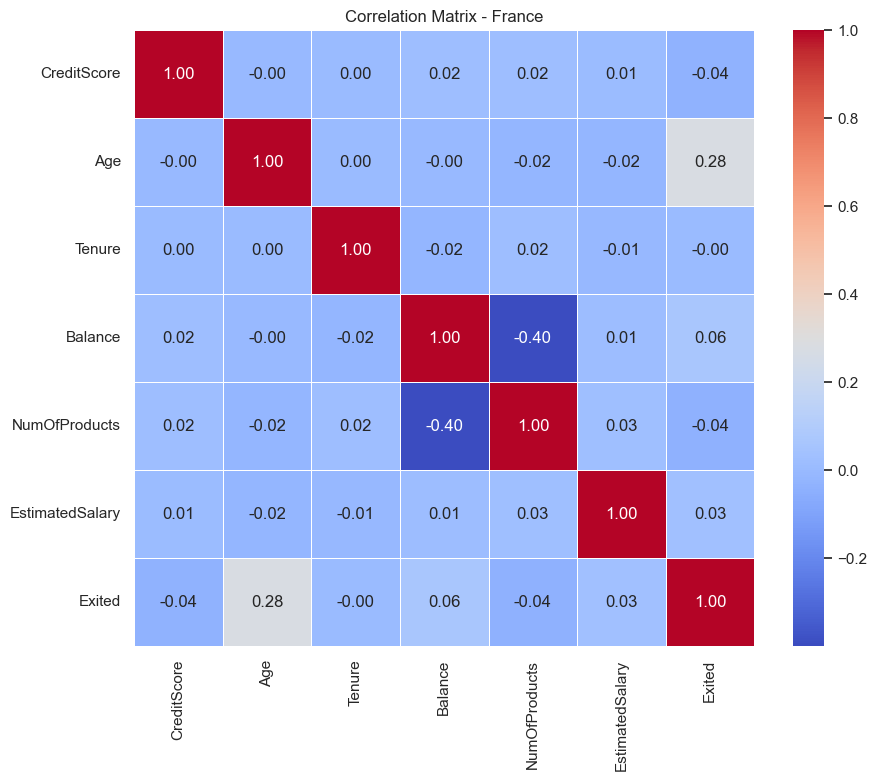

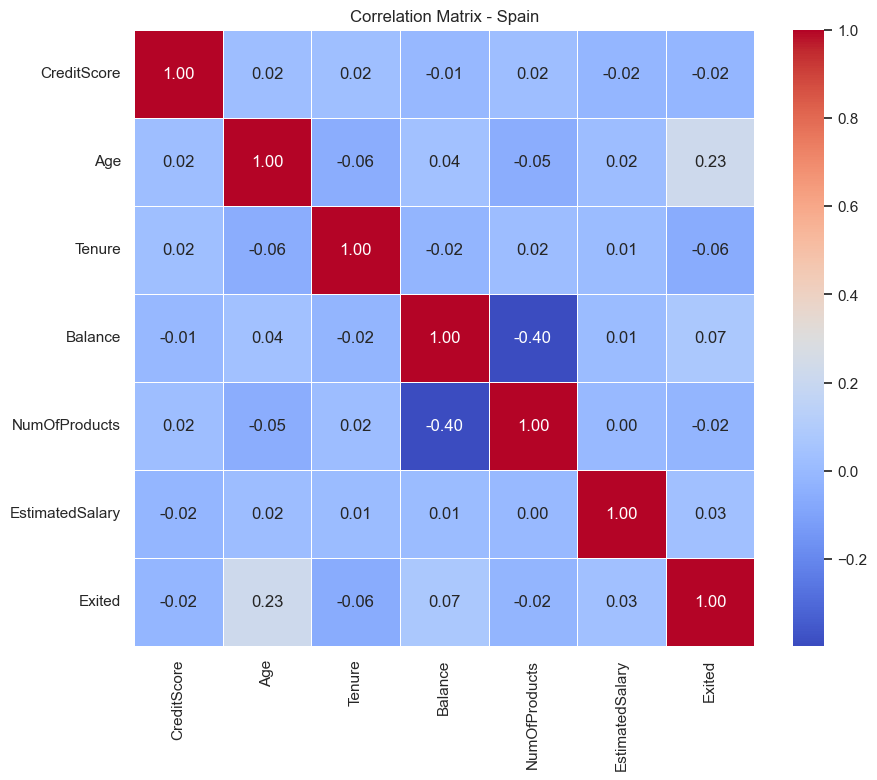

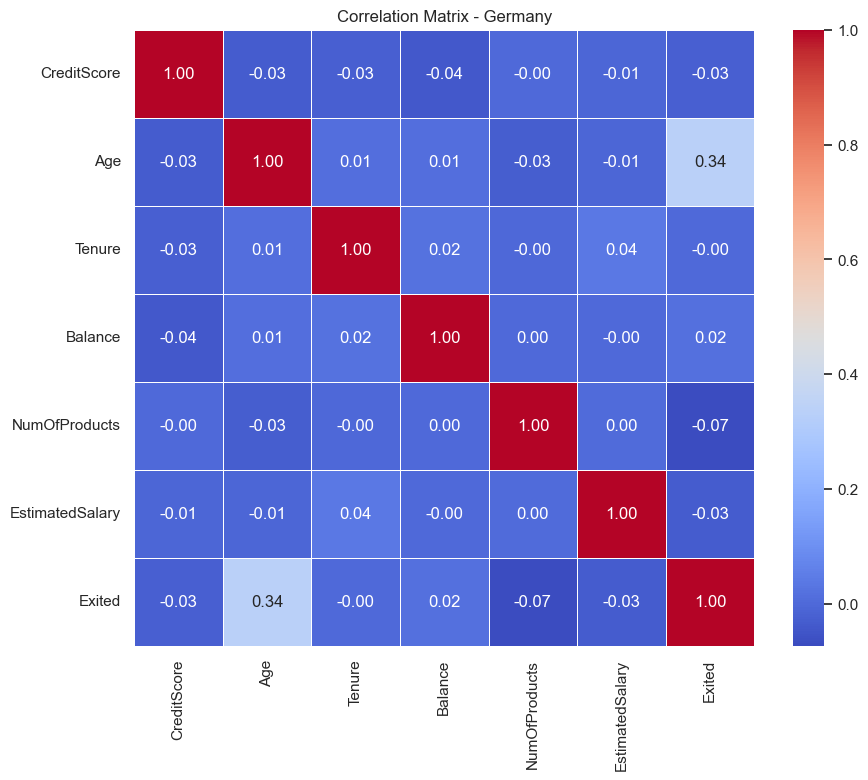

In [40]:
# Correlation matrix for each country (excluding categorical features)
def plot_correlation_matrix(df, country_name):
    # Select only numerical columns
    numerical_df = df.select_dtypes(include=[np.number])

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    corr = numerical_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix - {country_name}')
    plt.show()

# Plot for each country
plot_correlation_matrix(df_france, "France")
plot_correlation_matrix(df_spain, "Spain")
plot_correlation_matrix(df_germany, "Germany")

#### Class Imbalance Analysis

Here we determine the distribution of the target feature "Exited" where we want to assess class imbalance that is a critical factor to implement Machine Learning Models

In [41]:
# Count the number of occurrences for each class in 'Exited'
exited_counts = df_cleaned['Exited'].value_counts()

print("Count of occurrences for each class in 'Exited':")
print(exited_counts)

Count of occurrences for each class in 'Exited':
Exited
0    7963
1    2037
Name: count, dtype: int64


In [42]:
# Split the dataset by country
df_france = df_cleaned[df_bank_churn['Geography'] == 'France']
df_spain = df_cleaned[df_bank_churn['Geography'] == 'Spain']
df_germany = df_cleaned[df_bank_churn['Geography'] == 'Germany']

print("France dataset size:", df_france.shape)
print("Spain dataset size:", df_spain.shape)
print("Germany dataset size:", df_germany.shape)

France dataset size: (5014, 10)
Spain dataset size: (2477, 10)
Germany dataset size: (2509, 10)


#### Region Specific Churn Analysis

If we train one global model it might not capture the unique patterns in each country. Training separate models for France, Spain and Germany would likely improve the accuracy of the predictions and allow us to identify features that are most important in each region.

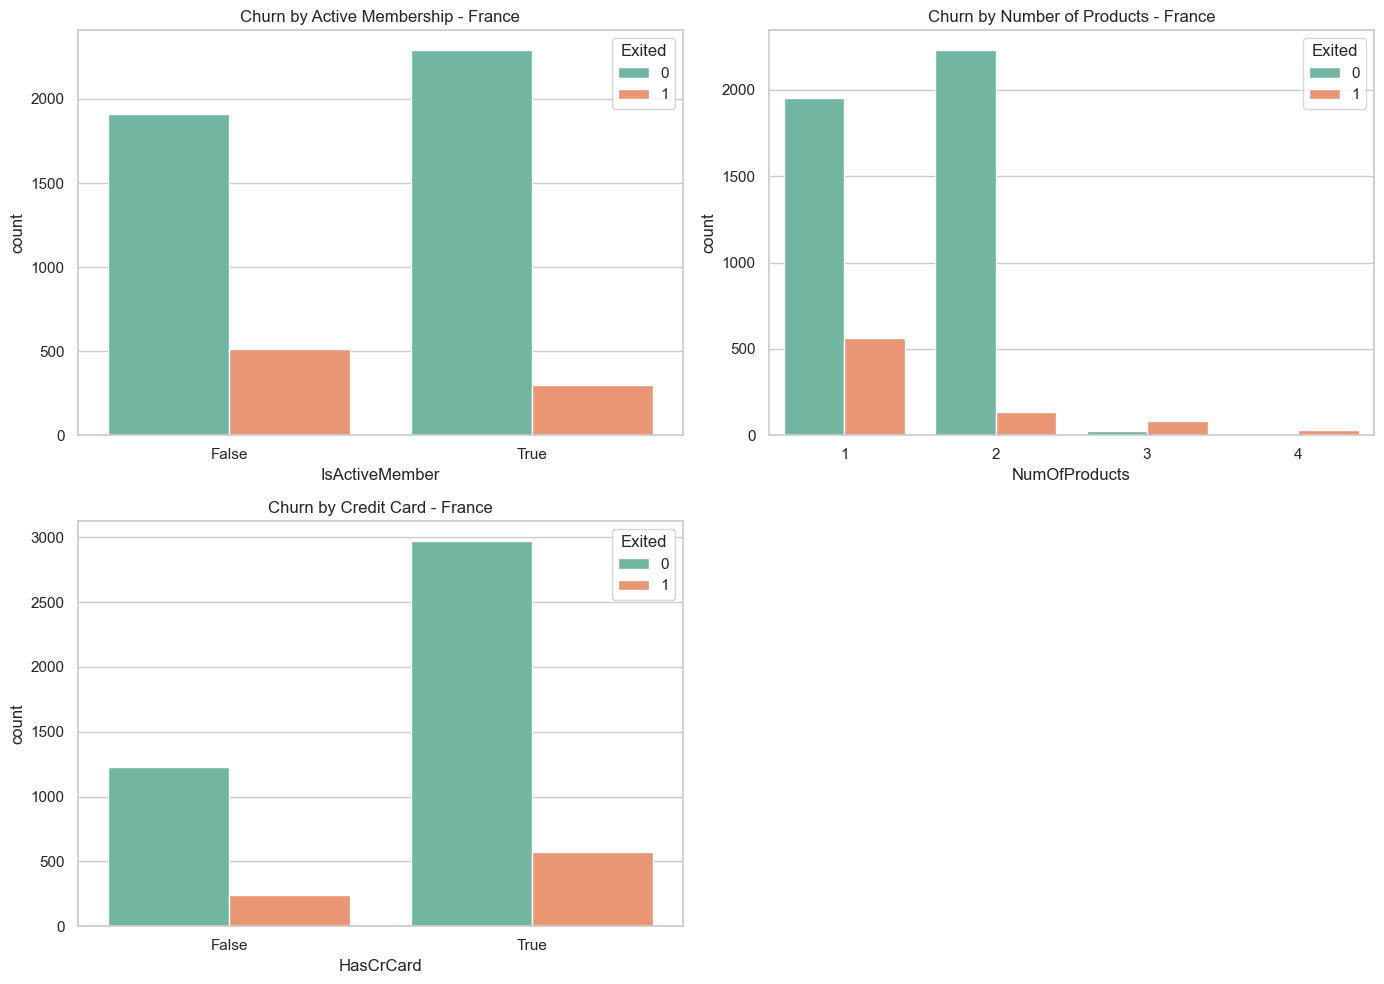

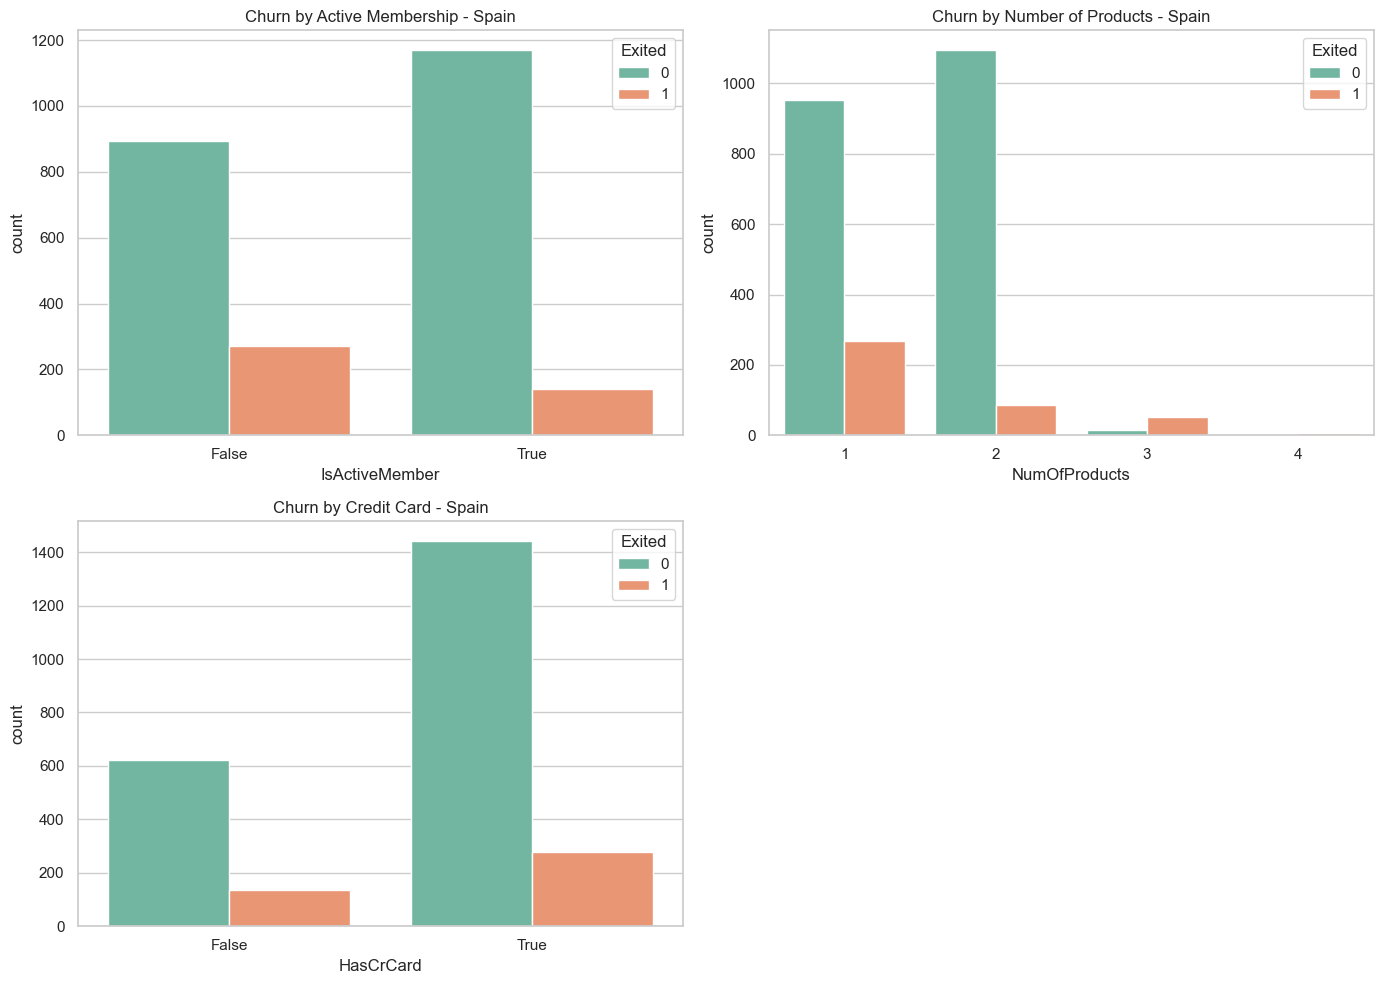

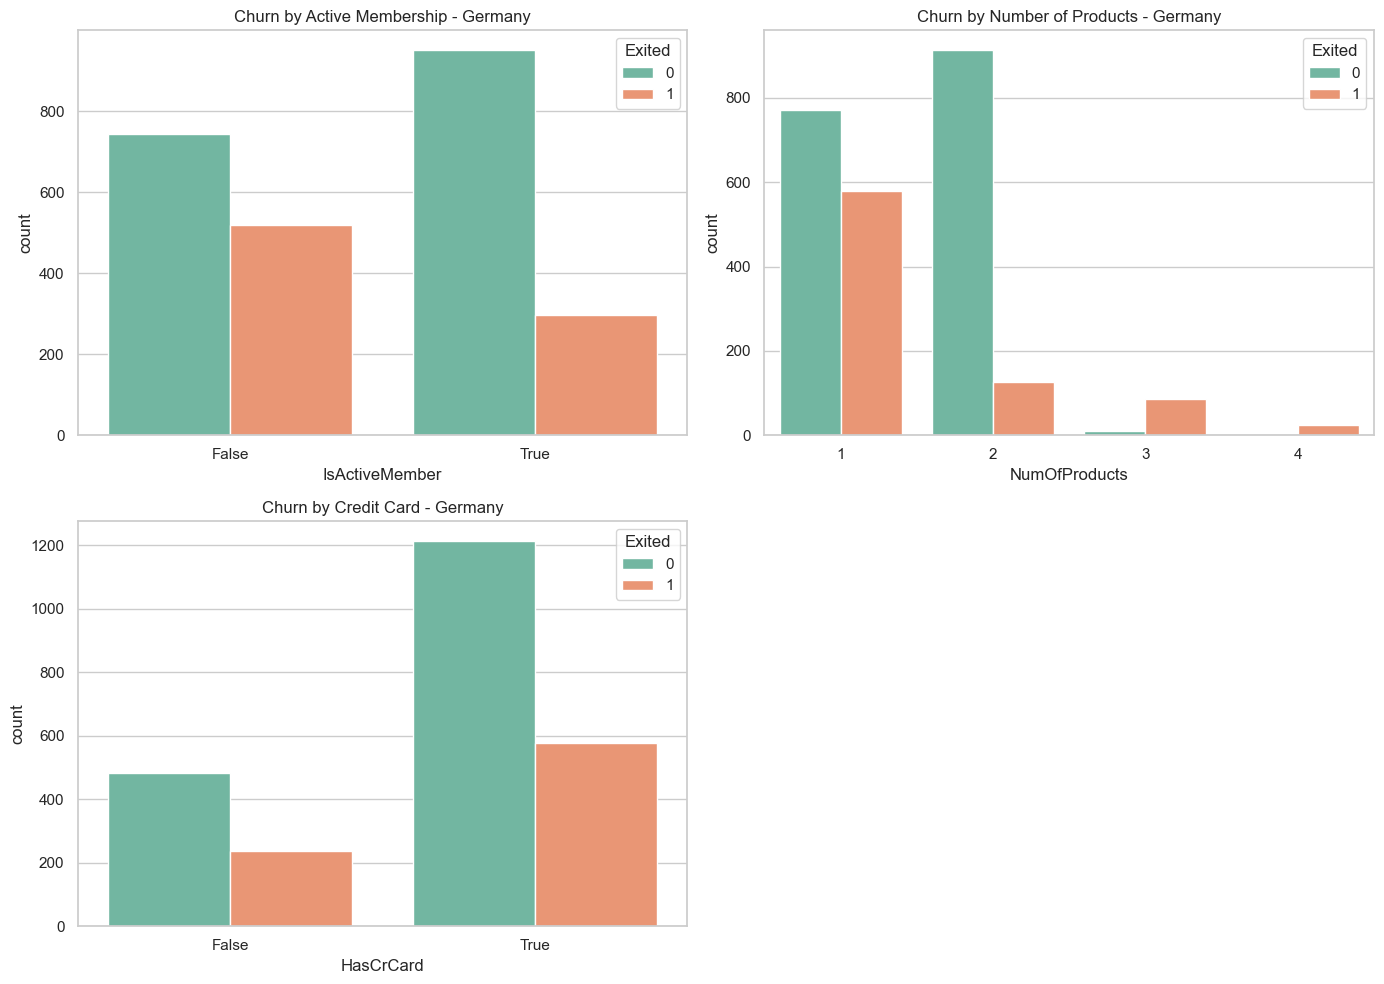

In [43]:
# Churn Distribution Across Categorical Features
# Function to plot churn distribution across categorical features
def plot_categorical_distribution(df, country_name):
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    sns.countplot(x='IsActiveMember', hue='Exited', data=df, palette='Set2')
    plt.title(f'Churn by Active Membership - {country_name}')

    plt.subplot(2, 2, 2)
    sns.countplot(x='NumOfProducts', hue='Exited', data=df, palette='Set2')
    plt.title(f'Churn by Number of Products - {country_name}')

    plt.subplot(2, 2, 3)
    sns.countplot(x='HasCrCard', hue='Exited', data=df, palette='Set2')
    plt.title(f'Churn by Credit Card - {country_name}')

    plt.tight_layout()
    plt.show()

# Plot for each country
plot_categorical_distribution(df_france, "France")
plot_categorical_distribution(df_spain, "Spain")
plot_categorical_distribution(df_germany, "Germany")

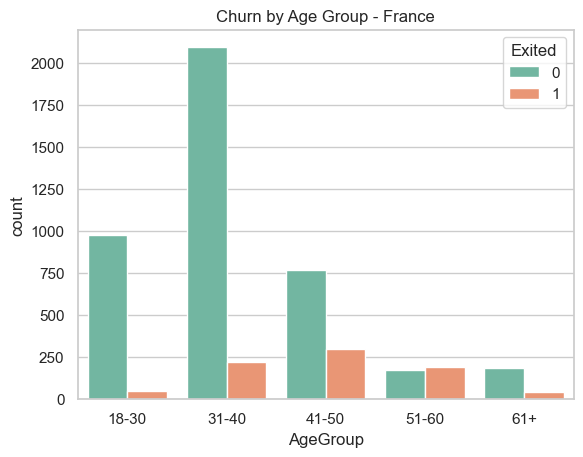

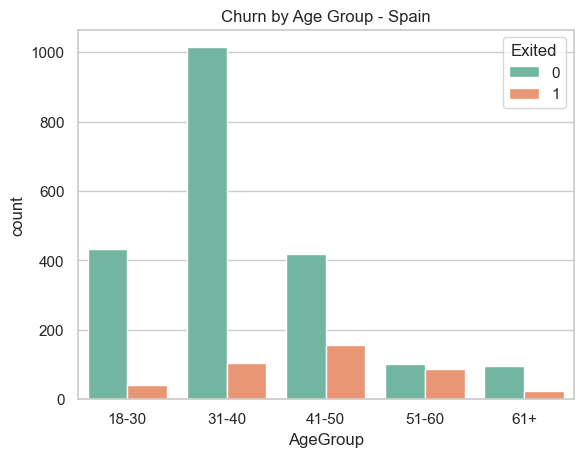

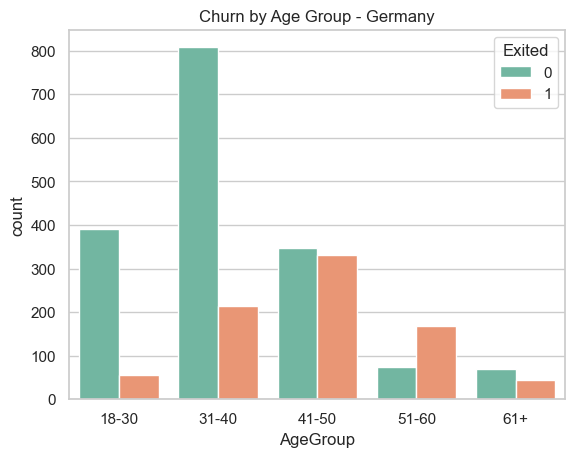

In [75]:
# Segmenting customers based on age
def age_segmentation(df, country_name):
    # Use .loc to avoid the SettingWithCopyWarning
    df.loc[:, 'AgeGroup'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '31-40', '41-50', '51-60', '61+'])

    # Plot churn by age group
    sns.countplot(x='AgeGroup', hue='Exited', data=df, palette='Set2')
    plt.title(f'Churn by Age Group - {country_name}')
    plt.show()

# Perform age segmentation for each country
age_segmentation(df_france, "France")
age_segmentation(df_spain, "Spain")
age_segmentation(df_germany, "Germany")

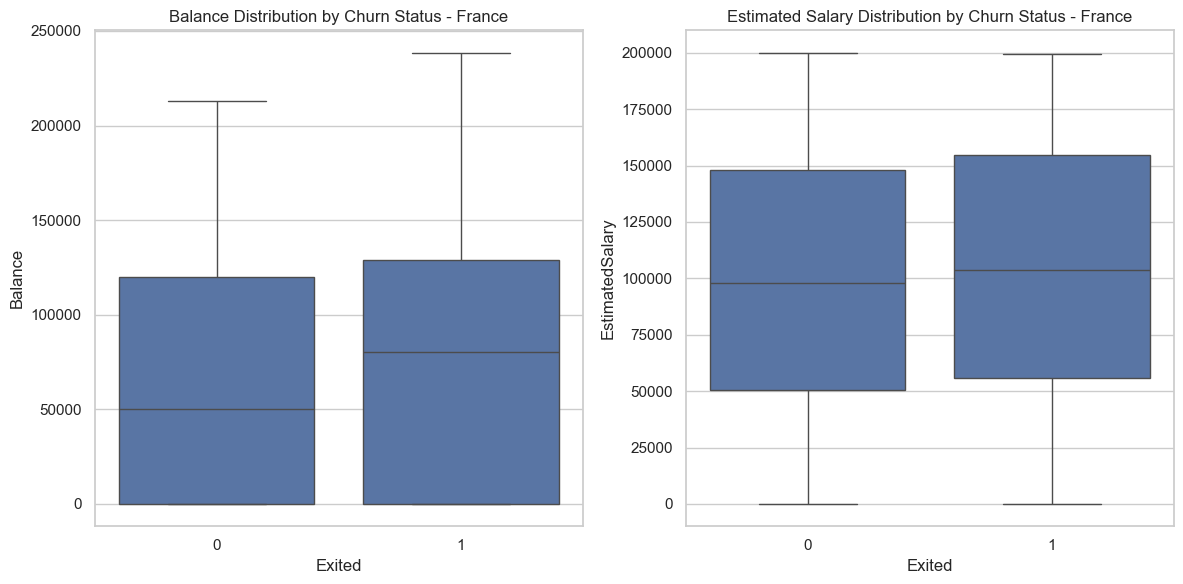

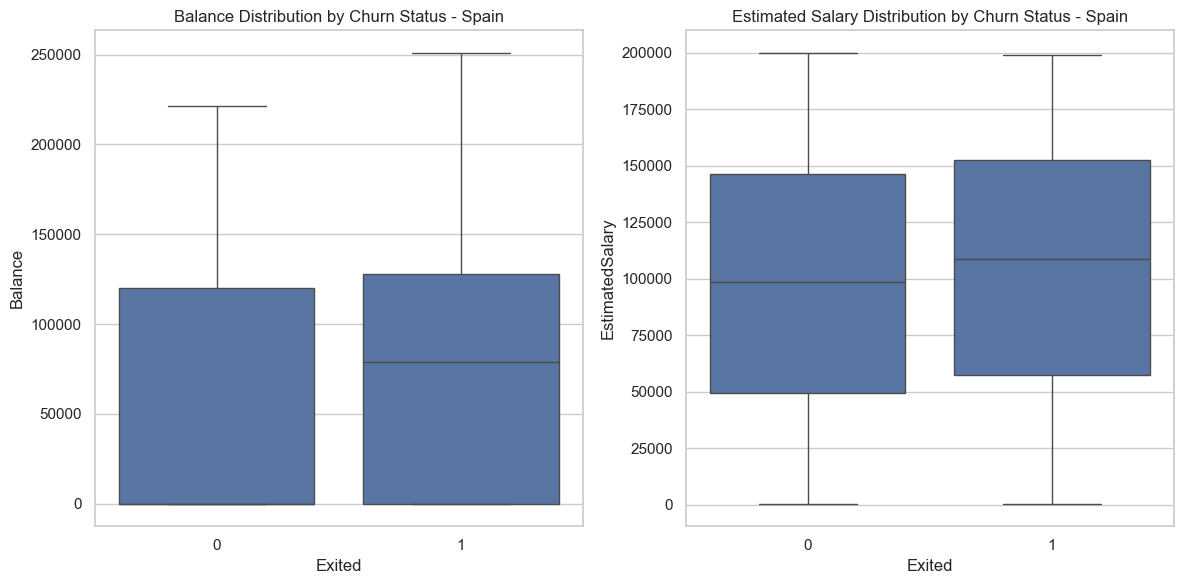

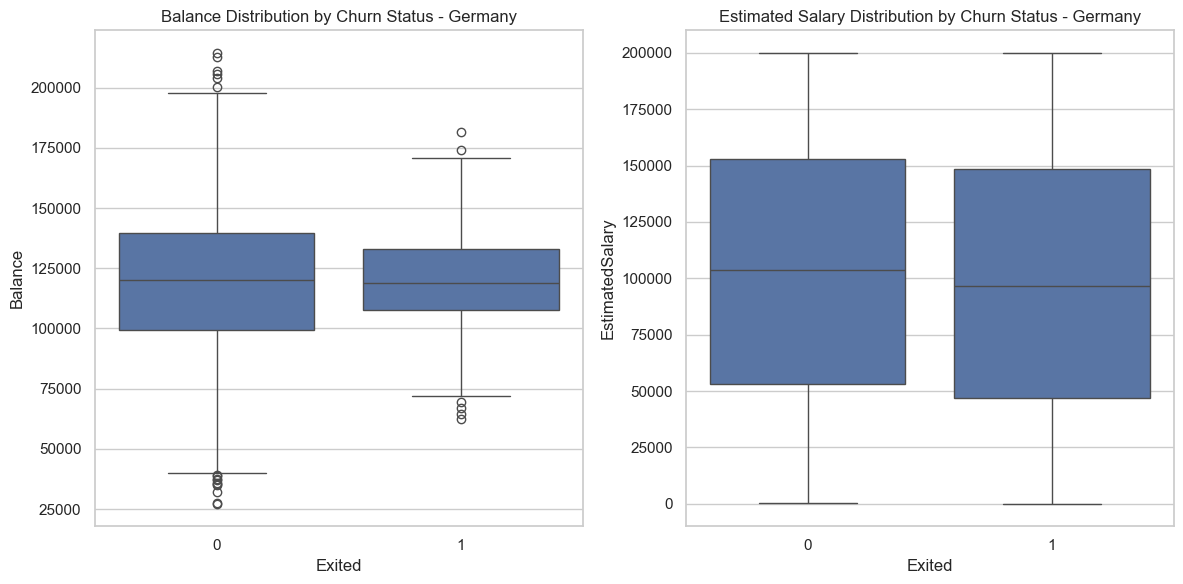

In [76]:
# Function to compare balance and salary for churned and non-churned customers
def balance_salary_comparison(df, country_name):
    plt.figure(figsize=(12, 6))

    # Balance distribution by churn status
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Exited', y='Balance', data=df)
    plt.title(f'Balance Distribution by Churn Status - {country_name}')

    # Estimated Salary distribution by churn status
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Exited', y='EstimatedSalary', data=df)
    plt.title(f'Estimated Salary Distribution by Churn Status - {country_name}')

    plt.tight_layout()
    plt.show()

# Compare balance and salary for each country
balance_salary_comparison(df_france, "France")
balance_salary_comparison(df_spain, "Spain")
balance_salary_comparison(df_germany, "Germany")

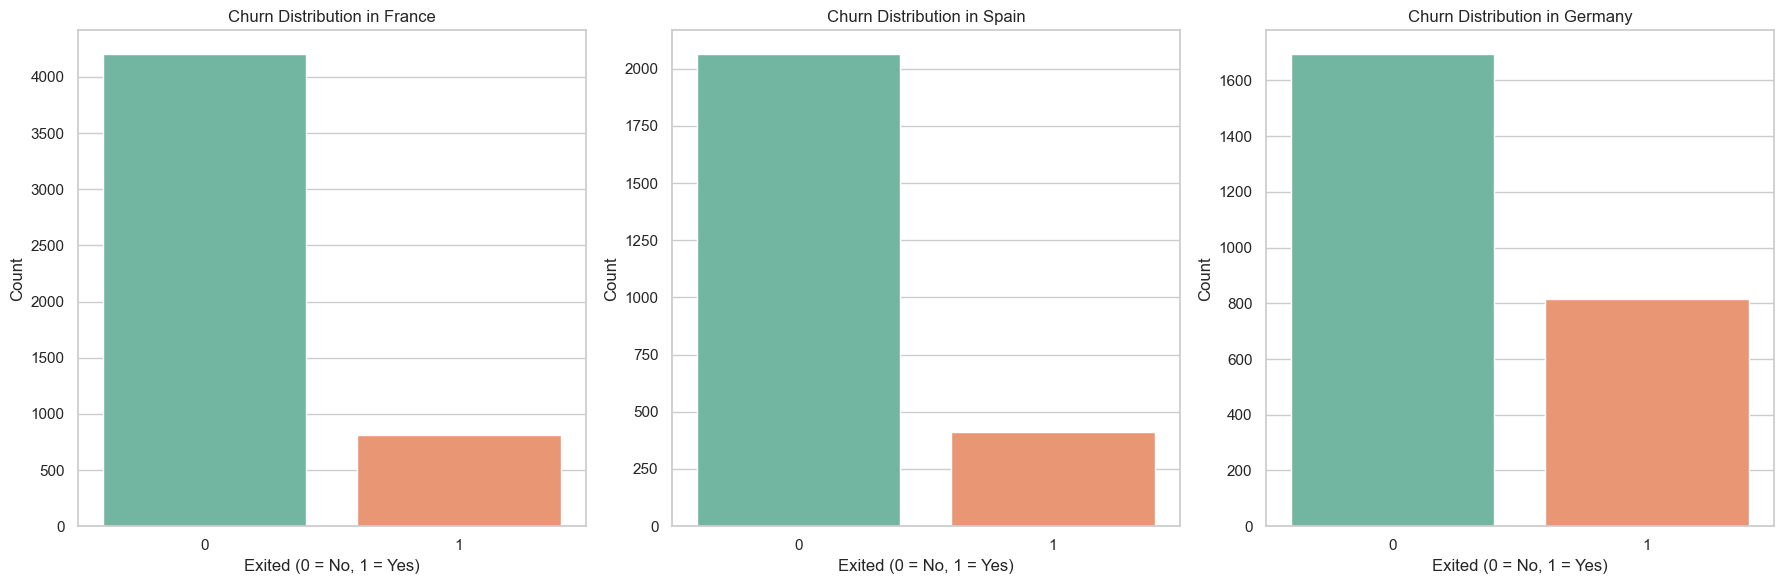

In [46]:
# Set the style of the plots
sns.set(style="whitegrid")

# Create a figure with 3 subplots (one for each country)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# France
sns.countplot(ax=axes[0], data=df_france, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[0].set_title('Churn Distribution in France')
axes[0].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[0].set_ylabel('Count')

# Spain
sns.countplot(ax=axes[1], data=df_spain, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[1].set_title('Churn Distribution in Spain')
axes[1].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[1].set_ylabel('Count')

# Germany
sns.countplot(ax=axes[2], data=df_germany, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[2].set_title('Churn Distribution in Germany')
axes[2].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[2].set_ylabel('Count')

plt.tight_layout()

plt.show()

#### Feature Selection
The dataset is conformed by 10 features after dropping the ones that could affect the analysis or that are not most relevant

In [47]:
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

target = 'Exited'

X_france = df_france[features]
y_france = df_france[target]

X_spain = df_spain[features]
y_spain = df_spain[target]

X_germany = df_germany[features]
y_germany = df_germany[target]

print("France selected data shape:", X_france.shape)
print("Spain selected data shape:", X_spain.shape)
print("Germany selected data shape:", X_germany.shape)

France selected data shape: (5014, 8)
Spain selected data shape: (2477, 8)
Germany selected data shape: (2509, 8)


#### One Hot Encoding

In [48]:
# One-hot encode the 'NumOfProducts' column
X_france = pd.get_dummies(df_france[features], columns=['NumOfProducts'], drop_first=True)
X_spain = pd.get_dummies(df_spain[features], columns=['NumOfProducts'], drop_first=True)
X_germany = pd.get_dummies(df_germany[features], columns=['NumOfProducts'], drop_first=True)

# The target remains the same
y_france = df_france[target]
y_spain = df_spain[target]
y_germany = df_germany[target]

# Verify the shape of the selected data after one-hot encoding
print("France selected data shape after encoding:", X_france.shape)
print("Spain selected data shape after encoding:", X_spain.shape)
print("Germany selected data shape after encoding:", X_germany.shape)

France selected data shape after encoding: (5014, 10)
Spain selected data shape after encoding: (2477, 10)
Germany selected data shape after encoding: (2509, 10)


## Modelling
Given the problem at hand, where we have labeled data for all entries, we will focus on Supervised Learning Algorithms. Considering the current dataset size and its potential for scalability, we have selected three types of models across varying levels of complexity:

	•	Simple Model: Logistic Regression
	•	Ensemble Model: Random Forest
	•	Complex Model: Support Vector Machines (SVM)

Since the target variable shows a class imbalance, two strategies will be applied to address this:

	•	Undersampling: Reducing the majority class to balance with the minority class.
	•	Oversampling: Increasing the minority class instances to match the majority class.

These techniques will be applied to ensure more balanced learning across models and to enhance their performance in predicting the minority class.


### Undersampled Dataset

In [49]:
# Function to perform undersampling
def undersample_data(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled
 
# France dataset
X_france_resampled, y_france_resampled = undersample_data(X_france, y_france)
print("France data shape after undersampling:", X_france_resampled.shape)
print("France target shape after undersampling:", y_france_resampled.shape)

# Spain dataset
X_spain_resampled, y_spain_resampled = undersample_data(X_spain, y_spain)
print("Spain data shape after undersampling:", X_spain_resampled.shape)
print("Spain target shape after undersampling:", y_spain_resampled.shape)

# Germany dataset
X_germany_resampled, y_germany_resampled = undersample_data(X_germany, y_germany)
print("Germany data shape after undersampling:", X_germany_resampled.shape)
print("Germany target shape after undersampling:", y_germany_resampled.shape)

France data shape after undersampling: (1620, 10)
France target shape after undersampling: (1620,)
Spain data shape after undersampling: (826, 10)
Spain target shape after undersampling: (826,)
Germany data shape after undersampling: (1628, 10)
Germany target shape after undersampling: (1628,)


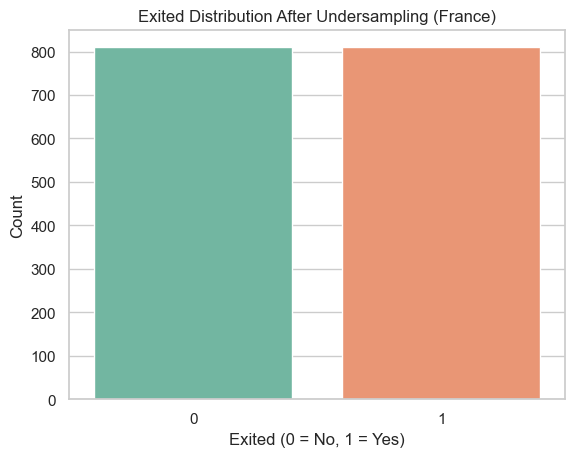

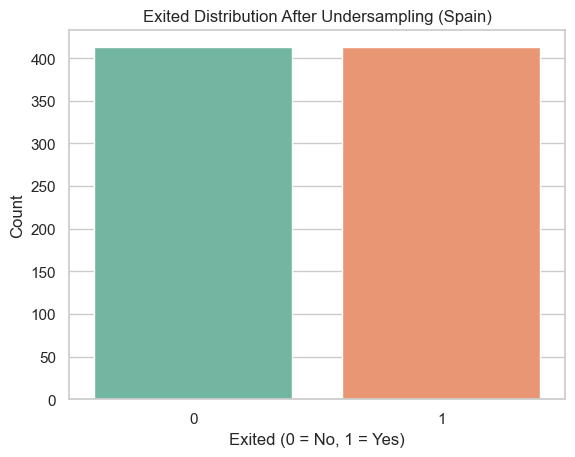

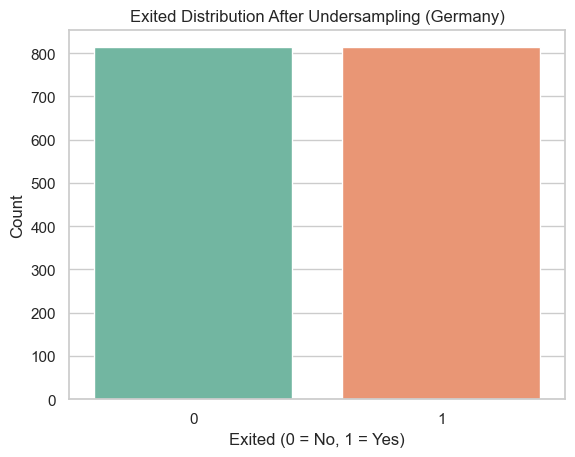

In [50]:
# Function to plot the distribution of the 'Exited' feature - To be sure that it was correctly done
def plot_exited_distribution(y_resampled, title):
    sns.countplot(x=y_resampled, palette='Set2', hue=y_resampled, legend=False)
    plt.title(title)
    plt.xlabel('Exited (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.show()
# Plot each country resampled
plot_exited_distribution(y_france_resampled, "Exited Distribution After Undersampling (France)")
plot_exited_distribution(y_spain_resampled, "Exited Distribution After Undersampling (Spain)")
plot_exited_distribution(y_germany_resampled, "Exited Distribution After Undersampling (Germany)")

#### Logistic Regression

In [51]:
%%time
# Function to train Logistic Regression and evaluate performance
def train_logistic_regression(X, y, country_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Logistic Regression model
    lr_model = LogisticRegression(random_state=42)

    # Train the model
    lr_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lr_model.predict(X_test)

    print(f"Logistic Regression Results for {country_name}:")
    print(classification_report(y_test, y_pred))

train_logistic_regression(X_france_resampled, y_france_resampled, "France")

train_logistic_regression(X_spain_resampled, y_spain_resampled, "Spain")

train_logistic_regression(X_germany_resampled, y_germany_resampled, "Germany")

Logistic Regression Results for France:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68       254
           1       0.65      0.61      0.63       232

    accuracy                           0.65       486
   macro avg       0.65      0.65      0.65       486
weighted avg       0.65      0.65      0.65       486

Logistic Regression Results for Spain:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       131
           1       0.65      0.72      0.68       117

    accuracy                           0.69       248
   macro avg       0.69      0.69      0.69       248
weighted avg       0.69      0.69      0.69       248

Logistic Regression Results for Germany:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       250
           1       0.66      0.69      0.68       239

    accuracy                           0.68       489
   macro

#### Random Forest

In [52]:
%%time
# Function to train Random Forest and evaluate performance
def train_random_forest(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    print(f"Random Forest Results for {country_name}:")
    print(classification_report(y_test, y_pred))

train_random_forest(X_france_resampled, y_france_resampled, "France")

train_random_forest(X_spain_resampled, y_spain_resampled, "Spain")

train_random_forest(X_germany_resampled, y_germany_resampled, "Germany")

Random Forest Results for France:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       254
           1       0.76      0.73      0.75       232

    accuracy                           0.76       486
   macro avg       0.76      0.76      0.76       486
weighted avg       0.76      0.76      0.76       486

Random Forest Results for Spain:
              precision    recall  f1-score   support

           0       0.73      0.80      0.77       131
           1       0.75      0.68      0.71       117

    accuracy                           0.74       248
   macro avg       0.74      0.74      0.74       248
weighted avg       0.74      0.74      0.74       248

Random Forest Results for Germany:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       250
           1       0.77      0.72      0.75       239

    accuracy                           0.76       489
   macro avg       0.76   

#### SVM

In [53]:
%%time
# Function to train SVM and evaluate performance
def train_svm(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the SVM model
    svm_model = SVC(random_state=42)

    # Train the model
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    print(f"SVM Results for {country_name}:")
    print(classification_report(y_test, y_pred))

train_svm(X_france_resampled, y_france_resampled, "France")

train_svm(X_spain_resampled, y_spain_resampled, "Spain")

train_svm(X_germany_resampled, y_germany_resampled, "Germany")

SVM Results for France:
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       254
           1       0.51      0.58      0.54       232

    accuracy                           0.53       486
   macro avg       0.54      0.54      0.53       486
weighted avg       0.54      0.53      0.53       486

SVM Results for Spain:
              precision    recall  f1-score   support

           0       0.58      0.49      0.53       131
           1       0.51      0.60      0.55       117

    accuracy                           0.54       248
   macro avg       0.54      0.54      0.54       248
weighted avg       0.55      0.54      0.54       248

SVM Results for Germany:
              precision    recall  f1-score   support

           0       0.71      0.24      0.35       250
           1       0.53      0.90      0.67       239

    accuracy                           0.56       489
   macro avg       0.62      0.57      0.51       489
we

### Error Analysis
#### Confusion Matrix

In [54]:
# Function to plot confusion matrices in a 2x3 grid 
def plot_confusion_matrices_grid(models, model_names, X_train, X_test, y_train, y_test, country_name):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    for i, (model, model_name) in enumerate(zip(models, model_names)):
        # Train the model
        model.fit(X_train, y_train)

        # Predictions on training data
        y_train_pred = model.predict(X_train)
        cm_train = confusion_matrix(y_train, y_train_pred)
        disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
        disp_train.plot(ax=axes[0, i], cmap=plt.cm.Blues, values_format='.2f')
        axes[0, i].set_title(f"{model_name} Confusion Matrix (Training) - {country_name}")

        # Predictions on test data
        y_test_pred = model.predict(X_test)
        cm_test = confusion_matrix(y_test, y_test_pred)
        disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
        disp_test.plot(ax=axes[1, i], cmap=plt.cm.Blues, values_format='.2f')
        axes[1, i].set_title(f"{model_name} Confusion Matrix (Validation) - {country_name}")

    # Adjust layout
    plt.tight_layout()
    plt.show()


models = [
    LogisticRegression(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True) 
]
model_names = ["Logistic Regression", "Random Forest", "SVM"]

##### Confusion Matrix France

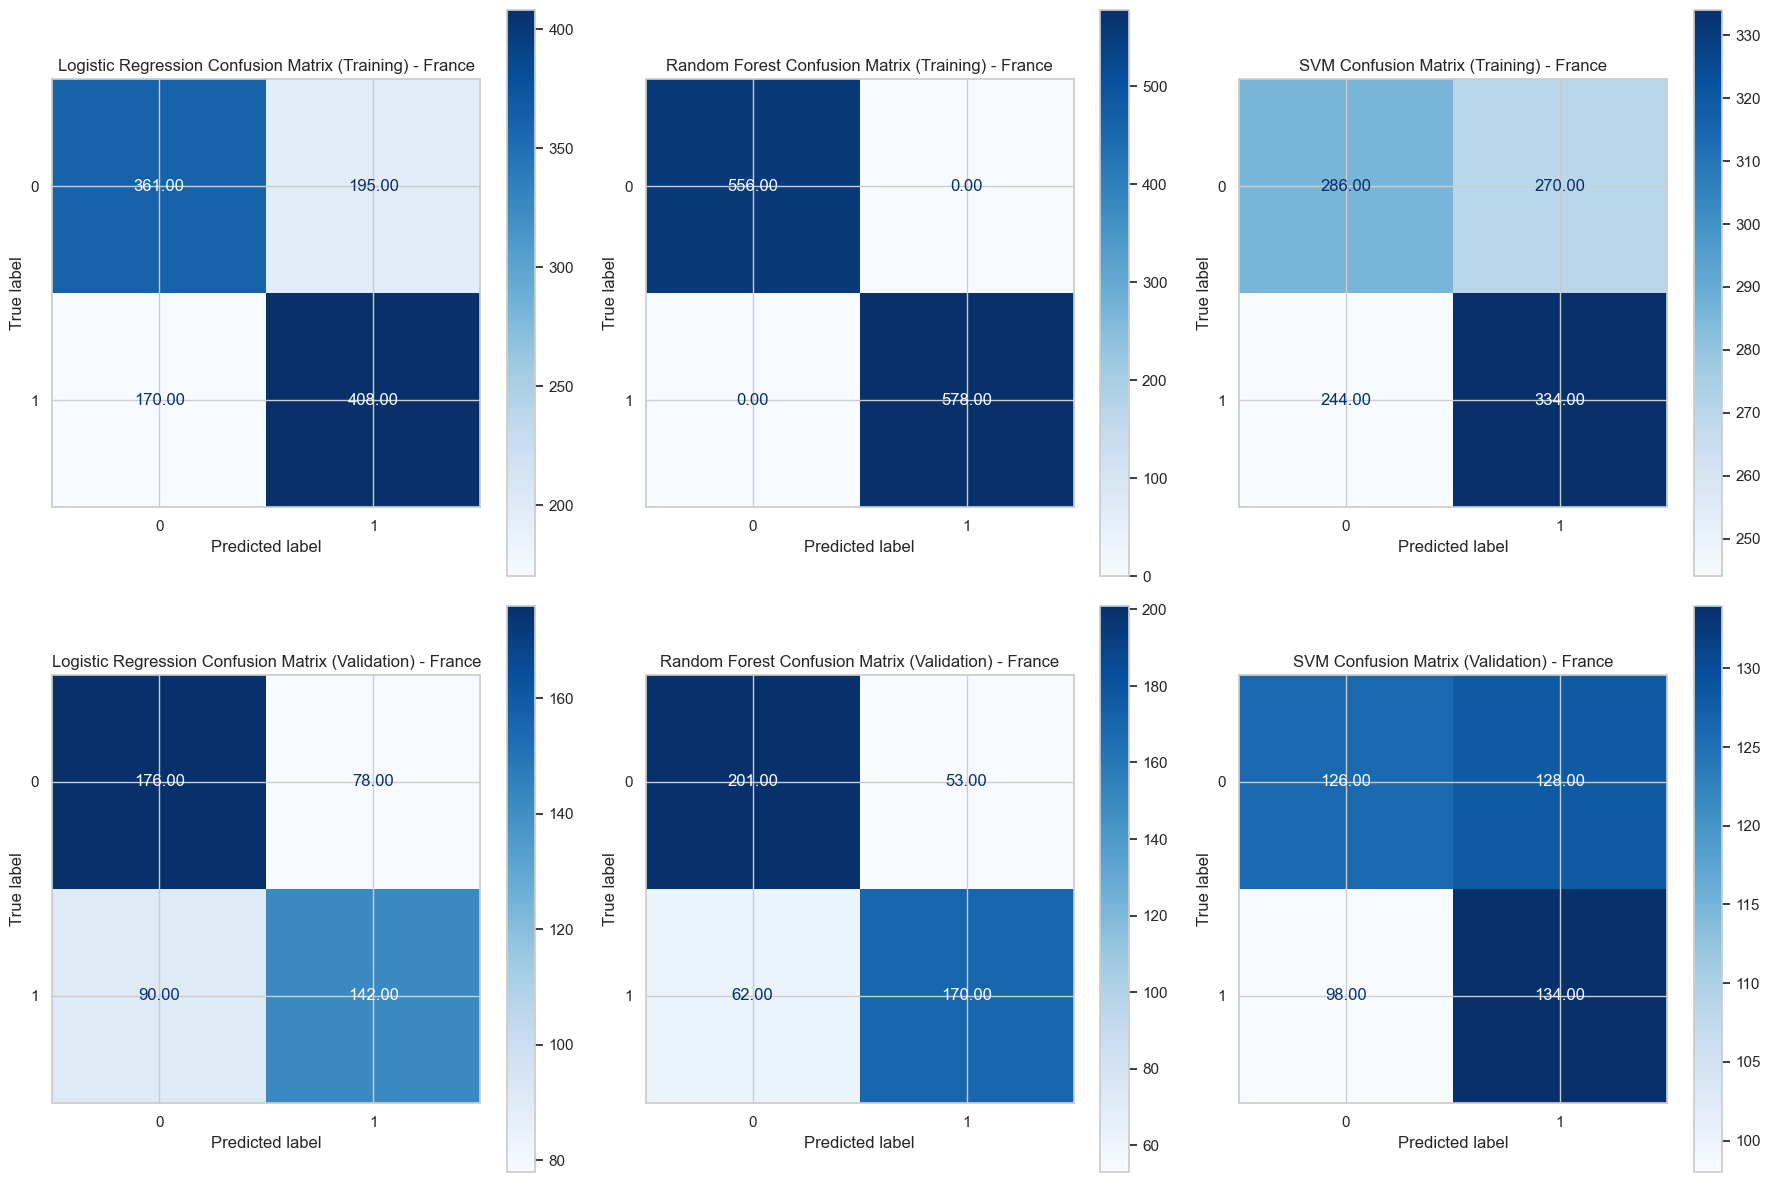

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_france_resampled, y_france_resampled, test_size=0.3, random_state=42)

plot_confusion_matrices_grid(models, model_names, X_train, X_test, y_train, y_test, "France")

##### Confusion Matrix Spain

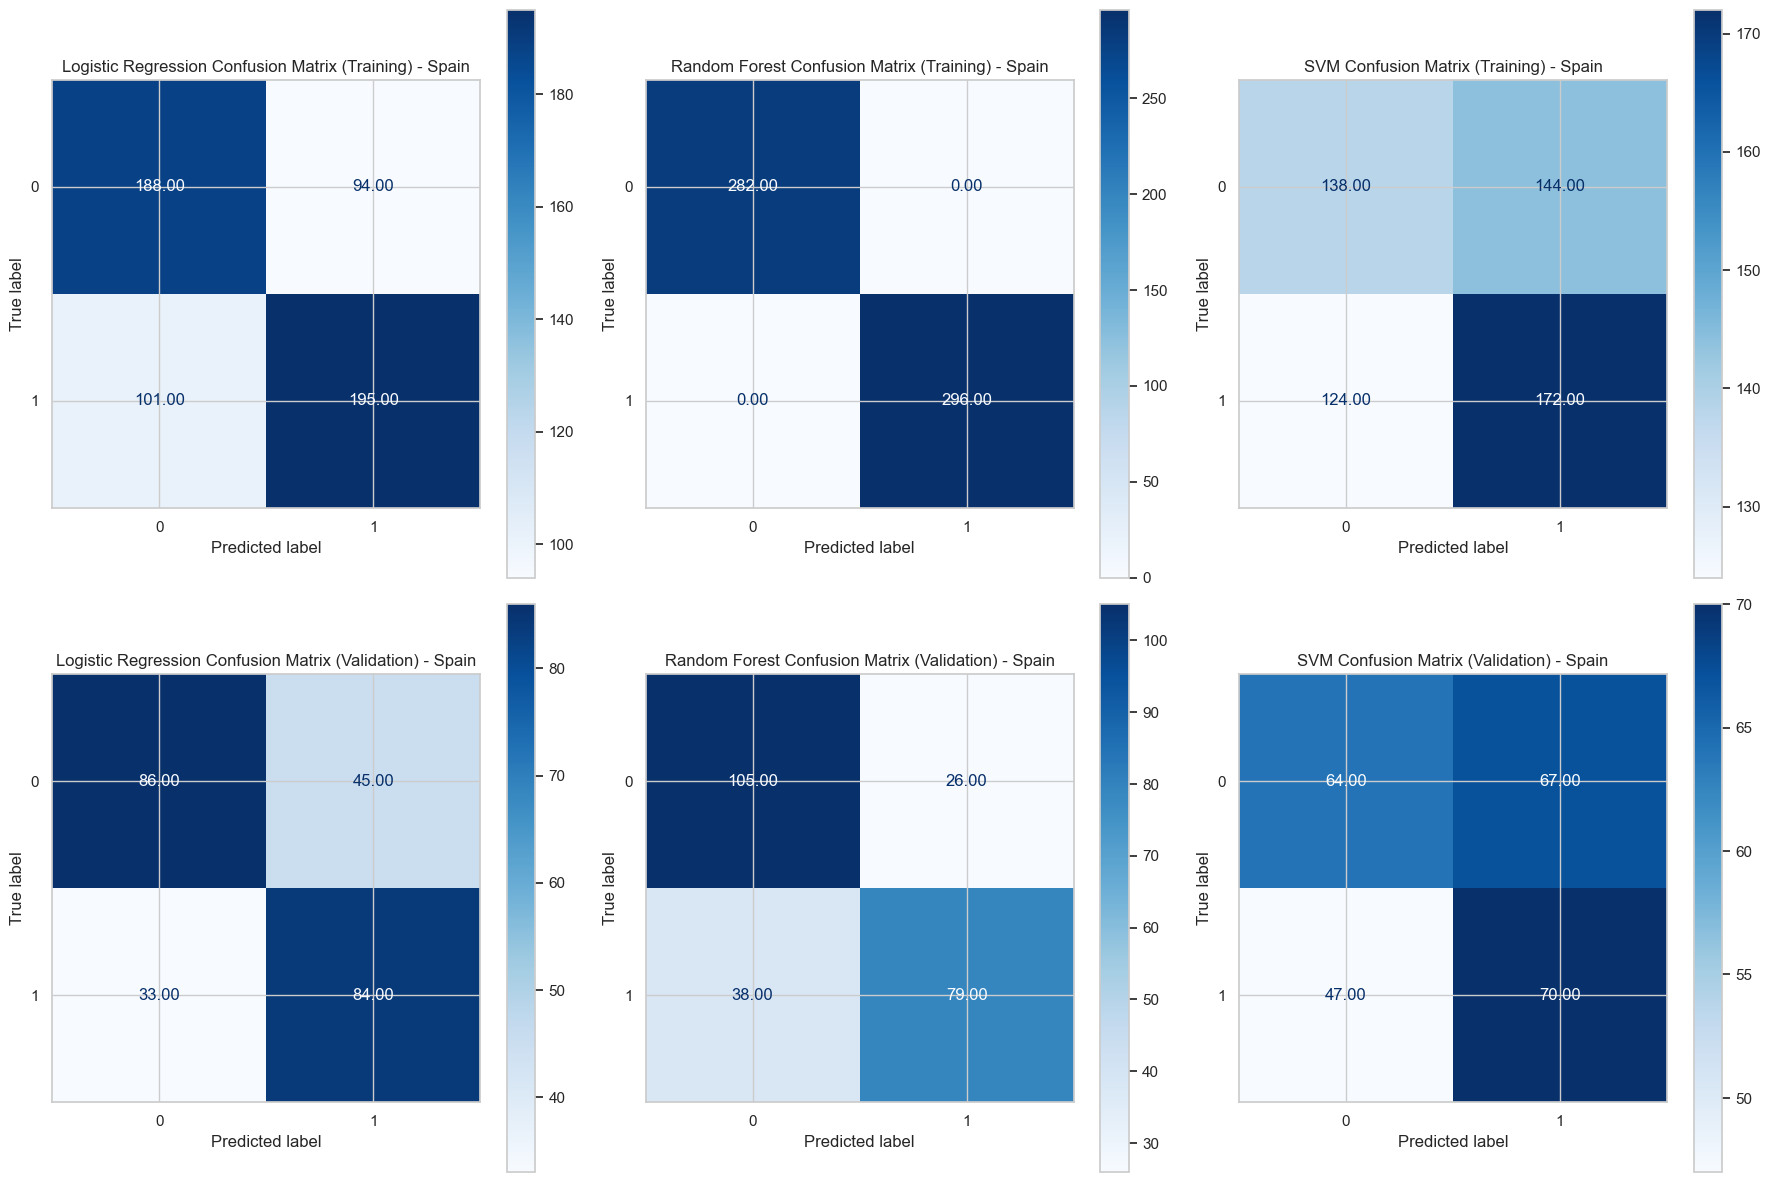

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_spain_resampled, y_spain_resampled, test_size=0.3, random_state=42)

plot_confusion_matrices_grid(models, model_names, X_train, X_test, y_train, y_test, "Spain")

##### Confusion Matrix Germany

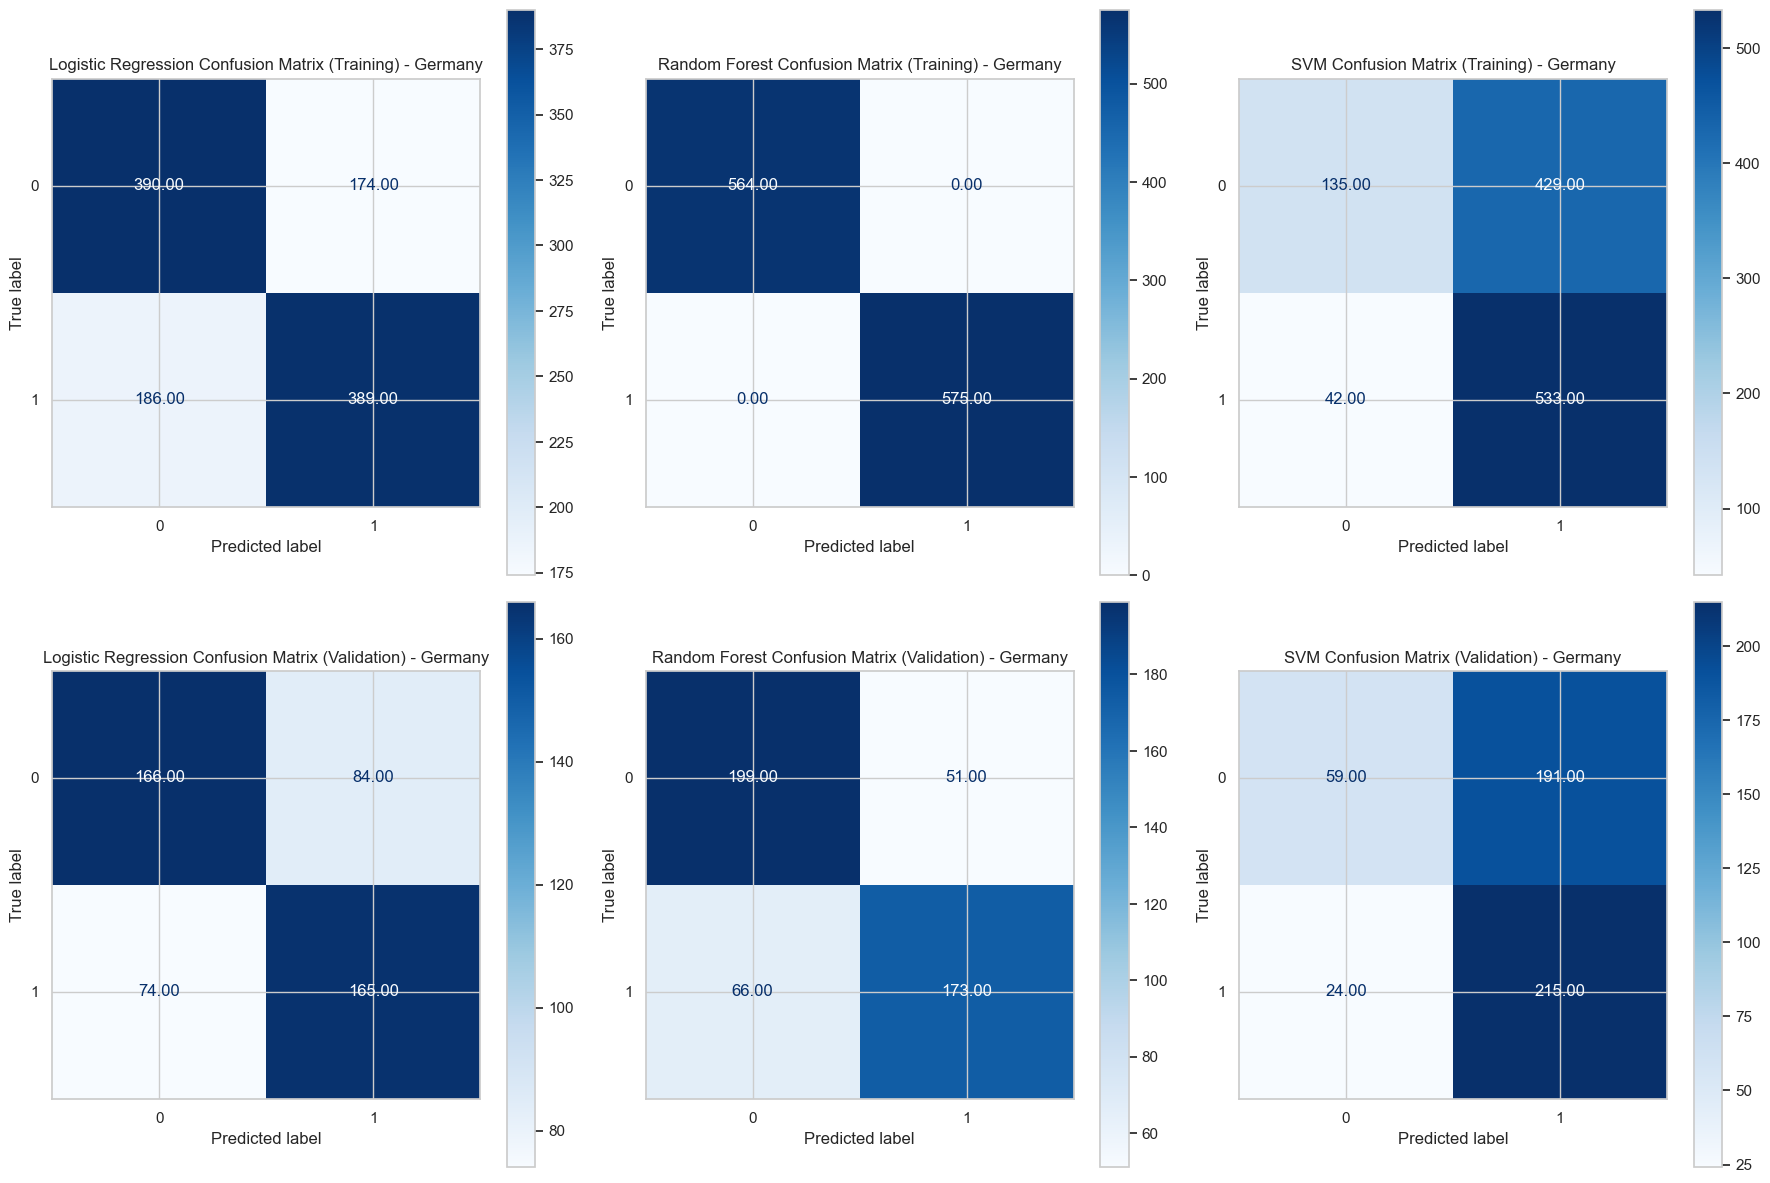

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_germany_resampled, y_germany_resampled, test_size=0.3, random_state=42)

plot_confusion_matrices_grid(models, model_names, X_train, X_test, y_train, y_test, "Germany")

#### Precision-Recall & ROC Curve  - All Models

In [58]:
# Function to plot Precision-Recall and ROC curves for multiple models
def plot_all_models_curves(models, model_names, X_train, X_test, y_train, y_test, country_name):
    plt.figure(figsize=(12, 6))

    # Subplot 1: Precision-Recall Curve
    plt.subplot(1, 2, 1)

    for model, model_name in zip(models, model_names):
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)

        plt.plot(recall, precision, marker='.', label=f"{model_name}")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Precision-Recall Curve ({country_name})")
    plt.legend()

    # Subplot 2: ROC Curve
    plt.subplot(1, 2, 2)

    for model, model_name in zip(models, model_names):
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, marker='.', label=f"{model_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', label="Random Guessing")  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve ({country_name})")
    plt.legend()

    plt.tight_layout()
    plt.show()

models = [
    LogisticRegression(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True)  # SVM with probability=True to get probabilities
]
model_names = ["Logistic Regression", "Random Forest", "SVM"]

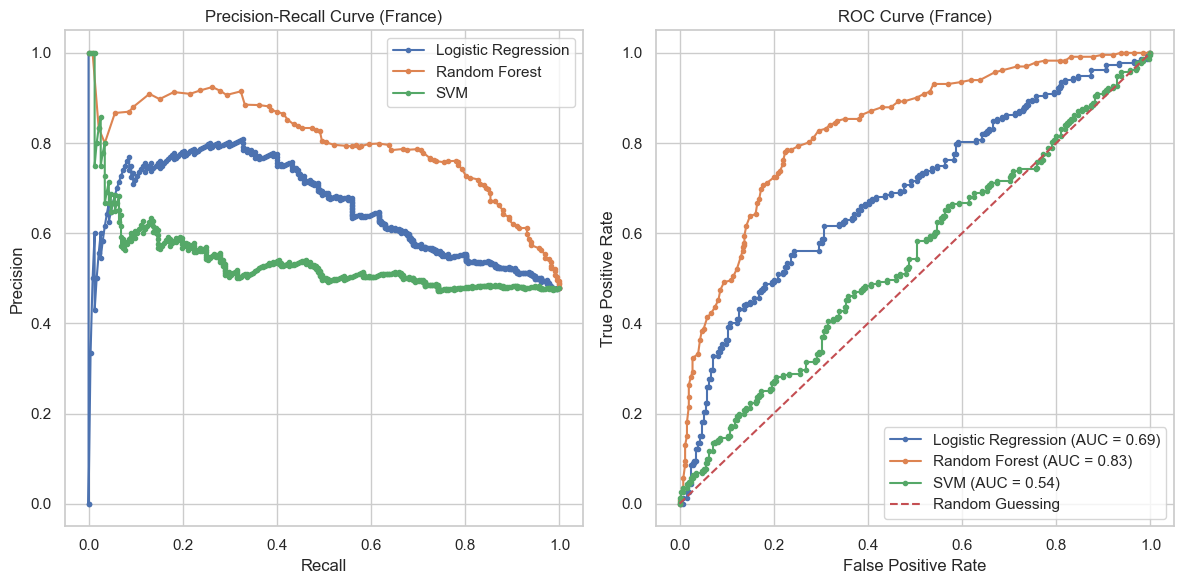

In [59]:
# France
X_train, X_test, y_train, y_test = train_test_split(X_france_resampled, y_france_resampled, test_size=0.3, random_state=42)

plot_all_models_curves(models, model_names, X_train, X_test, y_train, y_test, "France")

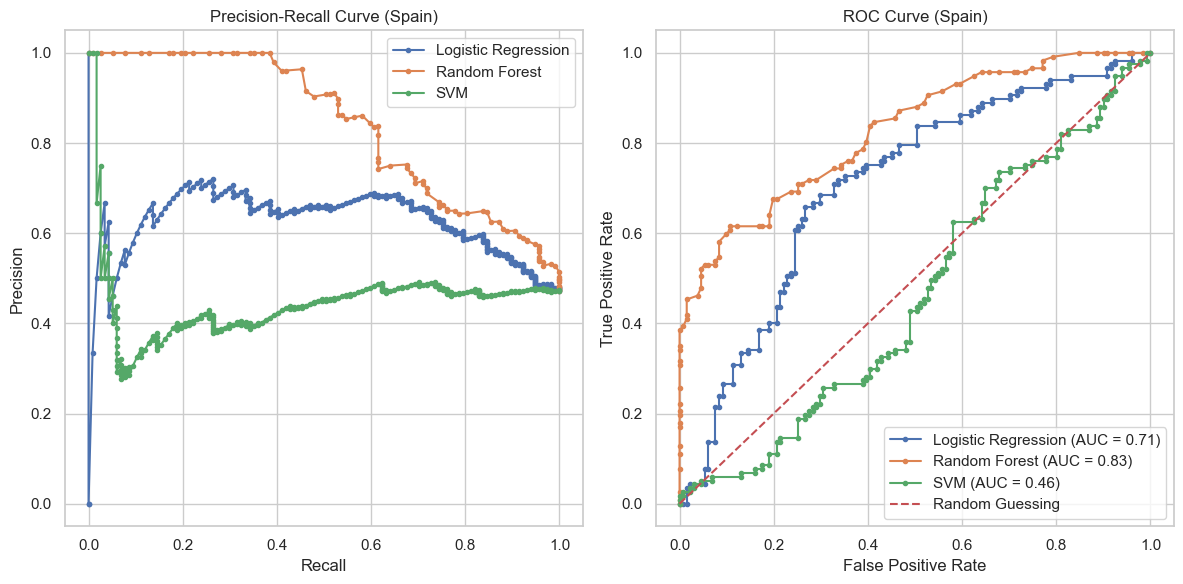

In [60]:
# Spain
X_train, X_test, y_train, y_test = train_test_split(X_spain_resampled, y_spain_resampled, test_size=0.3, random_state=42)

plot_all_models_curves(models, model_names, X_train, X_test, y_train, y_test, "Spain")

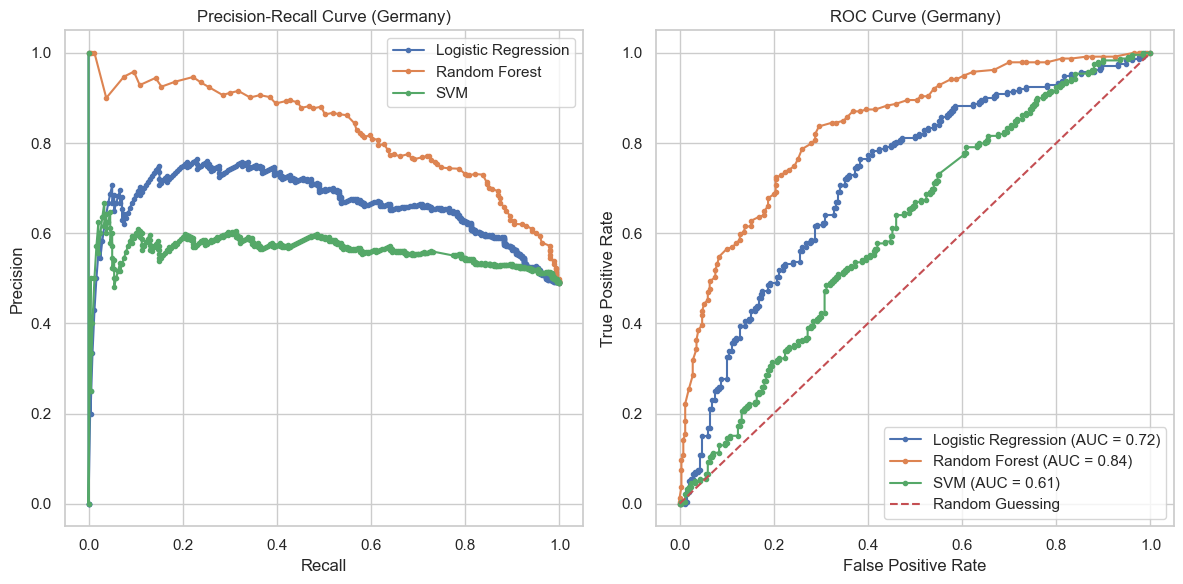

In [61]:
# Germany
X_train, X_test, y_train, y_test = train_test_split(X_germany_resampled, y_germany_resampled, test_size=0.3, random_state=42)

plot_all_models_curves(models, model_names, X_train, X_test, y_train, y_test, "Germany")

### Oversample Dataset

In [62]:
# Function to apply SMOTE for oversampling
def oversample_data(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Apply SMOTE to the France dataset
X_france_oversampled, y_france_oversampled = oversample_data(X_france, y_france)
print("France oversampled data shape:", X_france_oversampled.shape)
print("France oversampled target shape:", y_france_oversampled.shape)

# Apply SMOTE to the Spain dataset
X_spain_oversampled, y_spain_oversampled = oversample_data(X_spain, y_spain)
print("Spain oversampled data shape:", X_spain_oversampled.shape)
print("Spain oversampled target shape:", y_spain_oversampled.shape)

# Apply SMOTE to the Germany dataset
X_germany_oversampled, y_germany_oversampled = oversample_data(X_germany, y_germany)
print("Germany oversampled data shape:", X_germany_oversampled.shape)
print("Germany oversampled target shape:", y_germany_oversampled.shape)

France oversampled data shape: (8408, 10)
France oversampled target shape: (8408,)
Spain oversampled data shape: (4128, 10)
Spain oversampled target shape: (4128,)
Germany oversampled data shape: (3390, 10)
Germany oversampled target shape: (3390,)


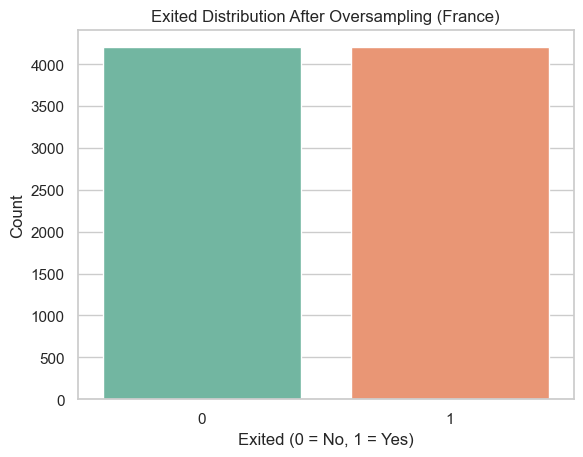

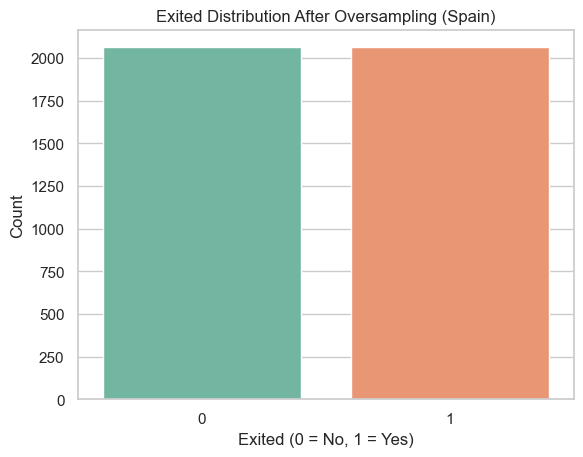

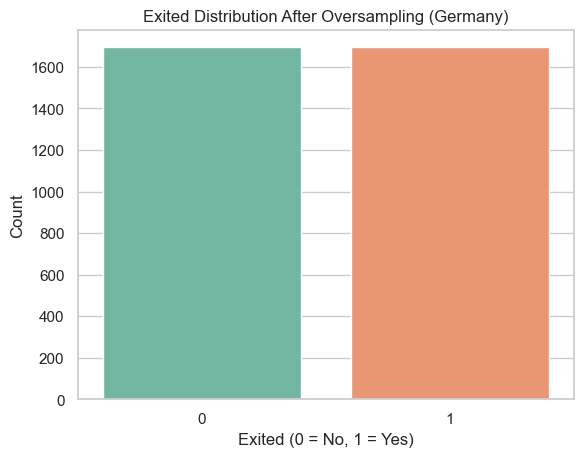

In [63]:
# Function to plot the distribution of the 'Exited' feature
def plot_exited_distribution(y_oversampled, title):
    sns.countplot(x=y_oversampled, palette='Set2', hue=y_oversampled, legend=False)
    plt.title(title)
    plt.xlabel('Exited (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.show()

# France
plot_exited_distribution(y_france_oversampled, "Exited Distribution After Oversampling (France)")

# Spain
plot_exited_distribution(y_spain_oversampled, "Exited Distribution After Oversampling (Spain)")

# Germany
plot_exited_distribution(y_germany_oversampled, "Exited Distribution After Oversampling (Germany)")

#### Logistic Regression

In [64]:
%%time
# Function to train Logistic Regression and evaluate performance
def train_logistic_regression(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Logistic Regression model
    lr_model = LogisticRegression(random_state=42)

    # Train the model
    lr_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lr_model.predict(X_test)


    print(f"Logistic Regression Results for {country_name}:")
    print(classification_report(y_test, y_pred))

train_logistic_regression(X_france_oversampled, y_france_oversampled, "France")

train_logistic_regression(X_spain_oversampled, y_spain_oversampled, "Spain")

train_logistic_regression(X_germany_oversampled, y_germany_oversampled, "Germany")

Logistic Regression Results for France:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67      1277
           1       0.66      0.70      0.68      1246

    accuracy                           0.68      2523
   macro avg       0.68      0.68      0.68      2523
weighted avg       0.68      0.68      0.68      2523

Logistic Regression Results for Spain:
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       635
           1       0.62      0.65      0.63       604

    accuracy                           0.63      1239
   macro avg       0.63      0.63      0.63      1239
weighted avg       0.64      0.63      0.63      1239

Logistic Regression Results for Germany:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       499
           1       0.71      0.69      0.70       518

    accuracy                           0.70      1017
   macro

#### Random Forest

In [65]:
%%time
# Function to train Random Forest and evaluate performance
def train_random_forest(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    print(f"Random Forest Results for {country_name}:")
    print(classification_report(y_test, y_pred))

train_random_forest(X_france_oversampled, y_france_oversampled, "France")

train_random_forest(X_spain_oversampled, y_spain_oversampled, "Spain")

train_random_forest(X_germany_oversampled, y_germany_oversampled, "Germany")

Random Forest Results for France:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1277
           1       0.83      0.86      0.84      1246

    accuracy                           0.84      2523
   macro avg       0.84      0.84      0.84      2523
weighted avg       0.84      0.84      0.84      2523

Random Forest Results for Spain:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       635
           1       0.83      0.86      0.84       604

    accuracy                           0.85      1239
   macro avg       0.85      0.85      0.85      1239
weighted avg       0.85      0.85      0.85      1239

Random Forest Results for Germany:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       499
           1       0.82      0.82      0.82       518

    accuracy                           0.82      1017
   macro avg       0.82   

#### Support Vector Machine (SVM)

In [66]:
%%time
# Function to train SVM and evaluate performance
def train_svm(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the SVM model
    svm_model = SVC(random_state=42)

    # Train the model
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    print(f"SVM Results for {country_name}:")
    print(classification_report(y_test, y_pred))

train_svm(X_france_oversampled, y_france_oversampled, "France")

train_svm(X_spain_oversampled, y_spain_oversampled, "Spain")

train_svm(X_germany_oversampled, y_germany_oversampled, "Germany")

SVM Results for France:
              precision    recall  f1-score   support

           0       0.55      0.48      0.51      1277
           1       0.53      0.60      0.56      1246

    accuracy                           0.54      2523
   macro avg       0.54      0.54      0.54      2523
weighted avg       0.54      0.54      0.54      2523

SVM Results for Spain:
              precision    recall  f1-score   support

           0       0.56      0.66      0.61       635
           1       0.56      0.45      0.50       604

    accuracy                           0.56      1239
   macro avg       0.56      0.56      0.55      1239
weighted avg       0.56      0.56      0.56      1239

SVM Results for Germany:
              precision    recall  f1-score   support

           0       0.71      0.21      0.32       499
           1       0.55      0.92      0.68       518

    accuracy                           0.57      1017
   macro avg       0.63      0.56      0.50      1017
we

### Error Analysis - Oversampled
#### Confusion Matrix

In [67]:
# Function to plot confusion matrices in a 2x3 grid (Training and Test for 3 models)
def plot_confusion_matrices_grid(models, model_names, X_train, X_test, y_train, y_test, country_name):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    for i, (model, model_name) in enumerate(zip(models, model_names)):
        # Train the model
        model.fit(X_train, y_train)

        # Predictions on training data
        y_train_pred = model.predict(X_train)
        cm_train = confusion_matrix(y_train, y_train_pred)
        disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
        disp_train.plot(ax=axes[0, i], cmap=plt.cm.Blues, values_format='.2f')
        axes[0, i].set_title(f"{model_name} Confusion Matrix (Training) - {country_name}")

        # Predictions on test data
        y_test_pred = model.predict(X_test)
        cm_test = confusion_matrix(y_test, y_test_pred)
        disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
        disp_test.plot(ax=axes[1, i], cmap=plt.cm.Blues, values_format='.2f')
        axes[1, i].set_title(f"{model_name} Confusion Matrix (Validation) - {country_name}")

    plt.tight_layout()
    plt.show()

models = [
    LogisticRegression(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True)  # SVM with probability=True to get probabilities
]
model_names = ["Logistic Regression", "Random Forest", "SVM"]

##### Confusion Matrix France

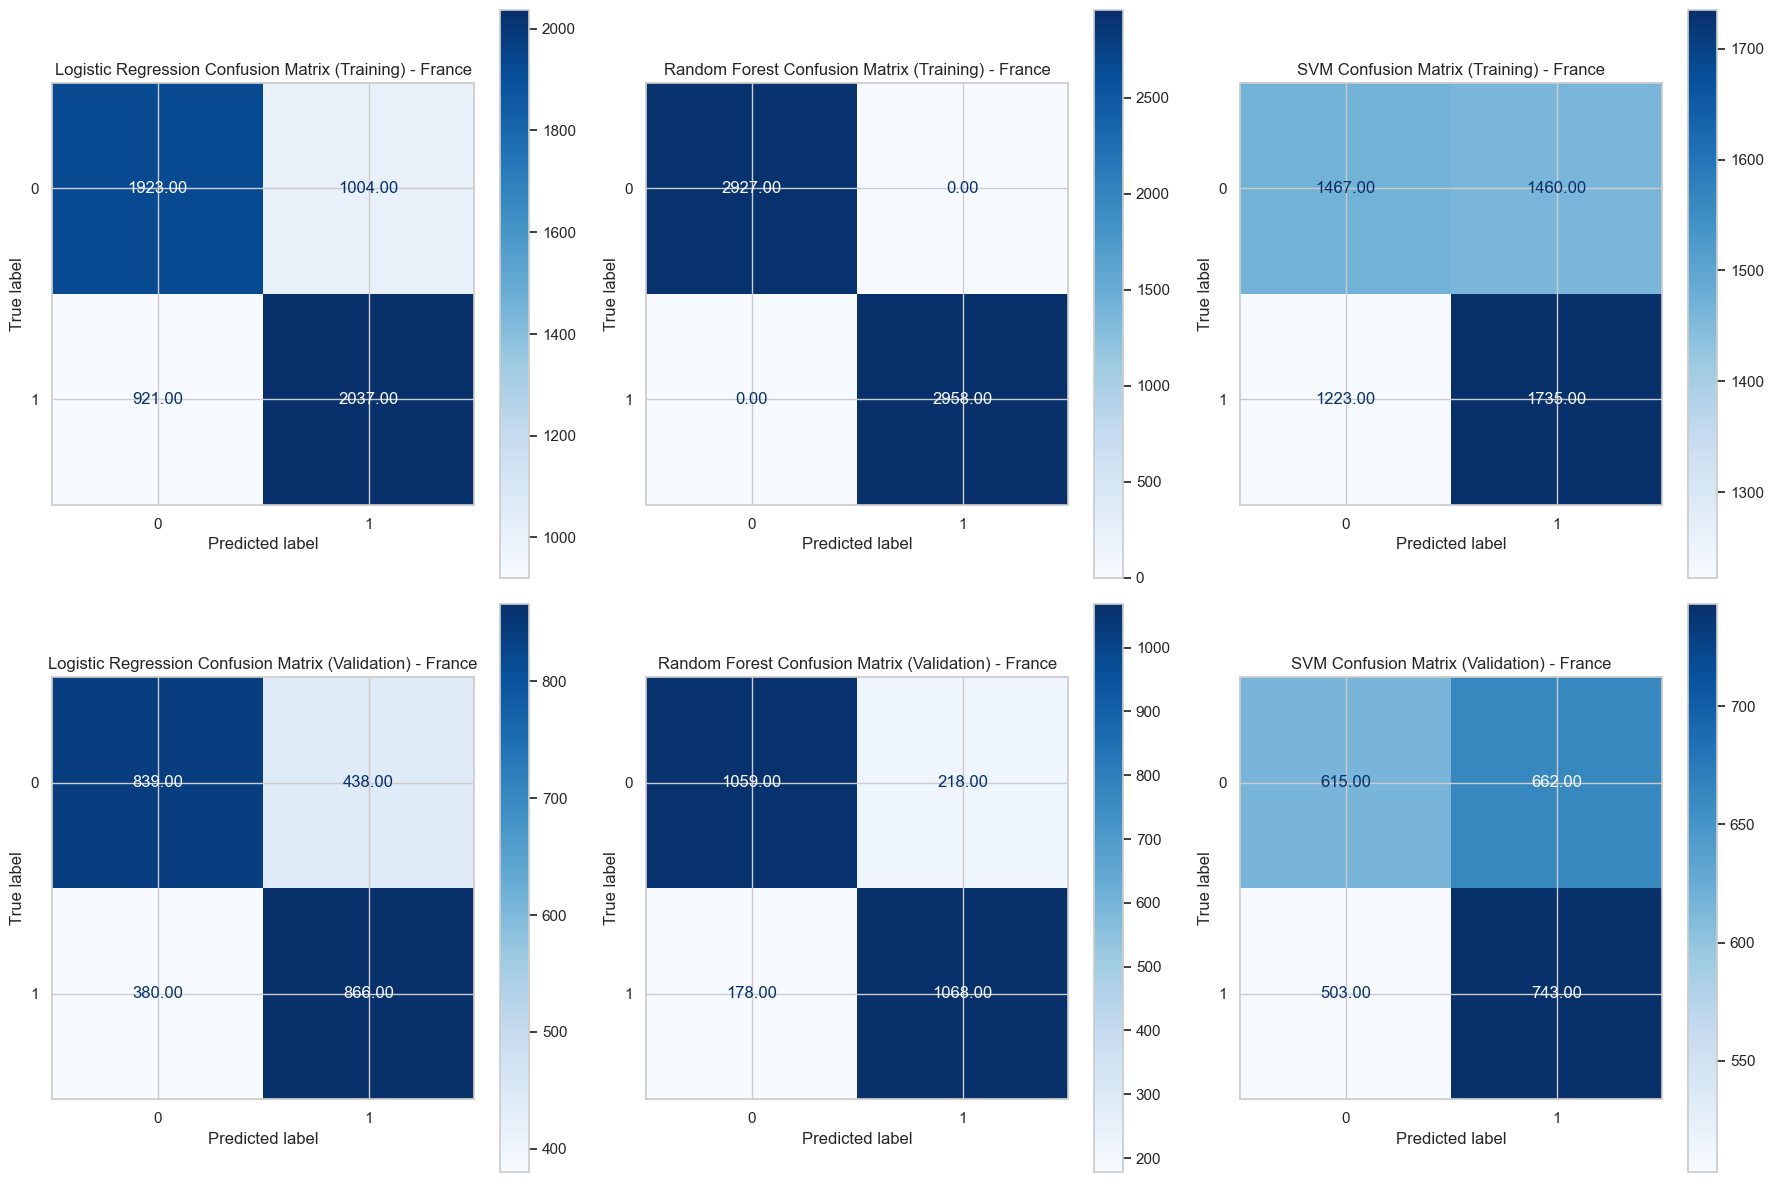

In [68]:
# France
X_train, X_test, y_train, y_test = train_test_split(X_france_oversampled, y_france_oversampled, test_size=0.3, random_state=42)

# Plot confusion matrices for all models on France dataset
plot_confusion_matrices_grid(models, model_names, X_train, X_test, y_train, y_test, "France")

##### Confusion Matrix Spain

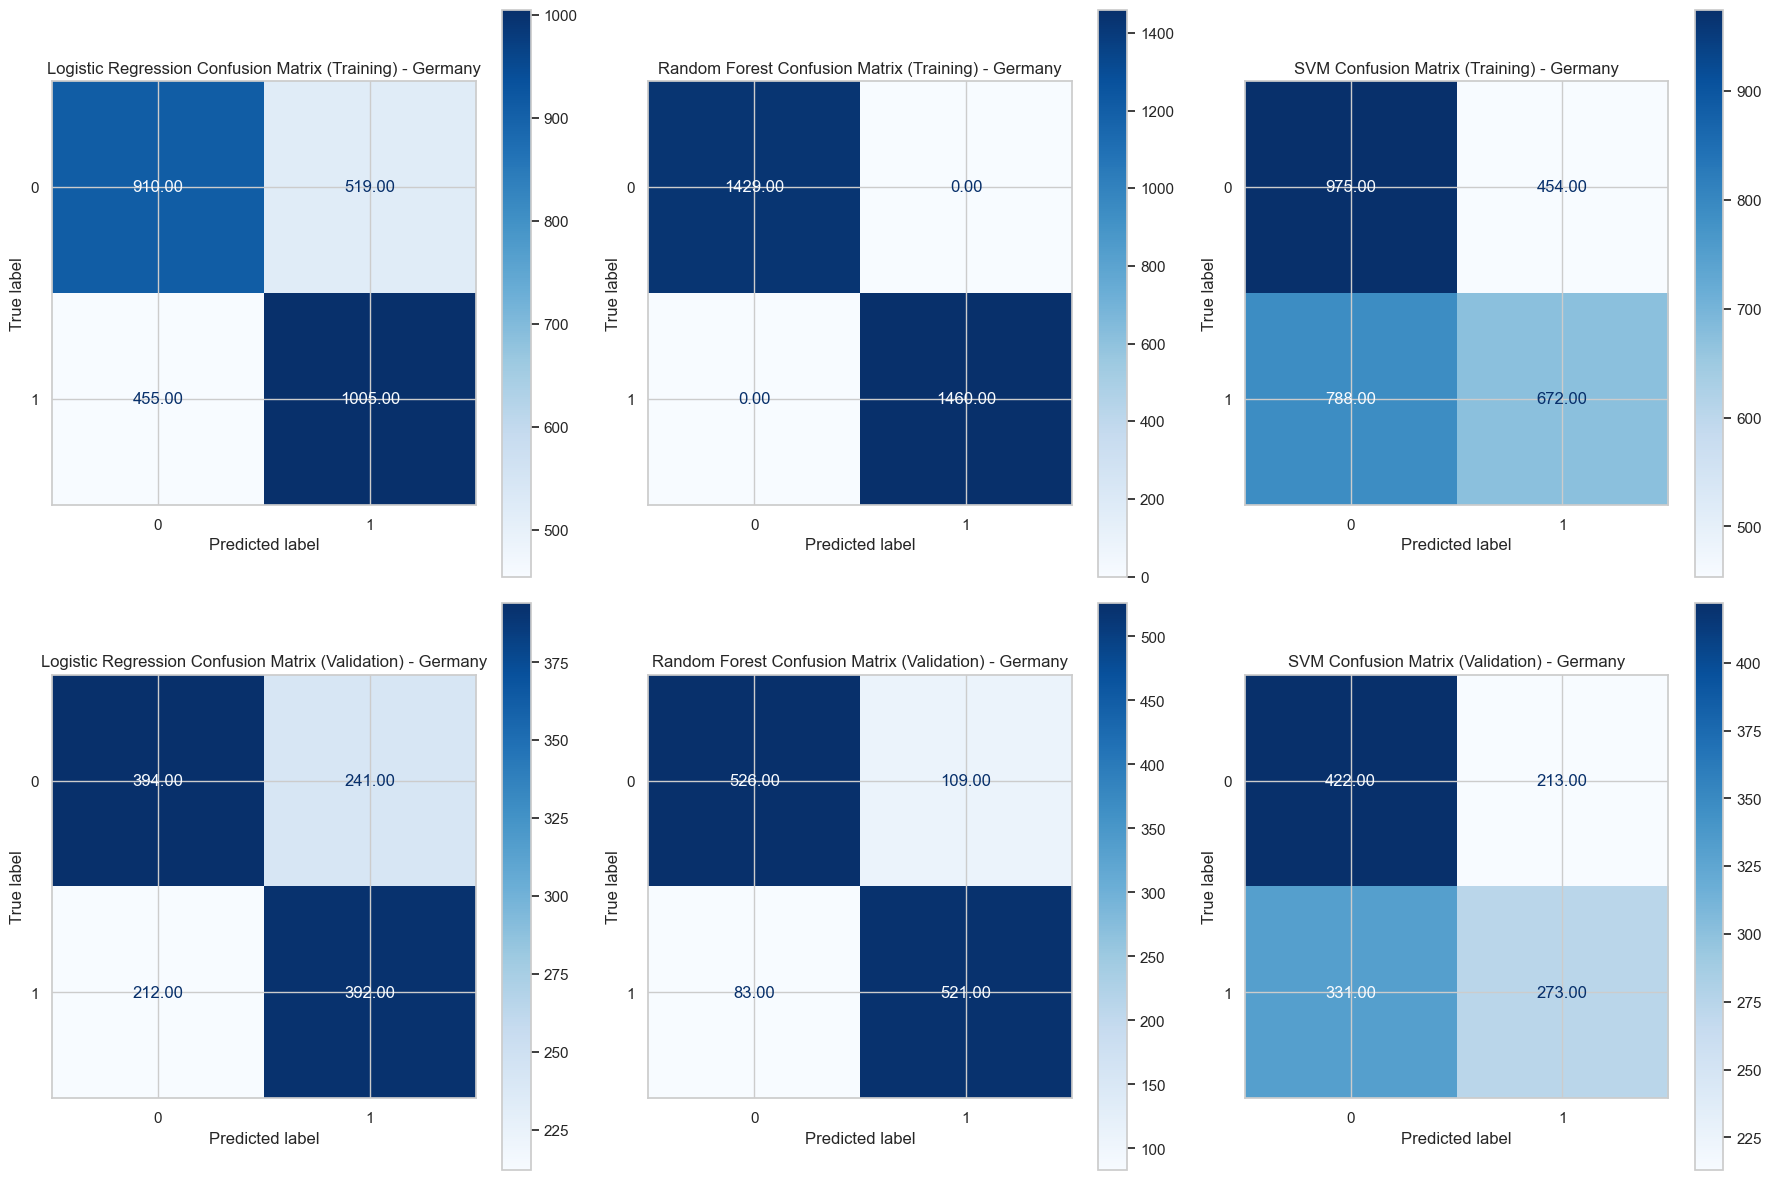

In [69]:
# Spain
X_train, X_test, y_train, y_test = train_test_split(X_spain_oversampled, y_spain_oversampled, test_size=0.3, random_state=42)

# Plot confusion matrices for all models on France dataset
plot_confusion_matrices_grid(models, model_names, X_train, X_test, y_train, y_test, "Germany")

##### Confusion Matrix Germany

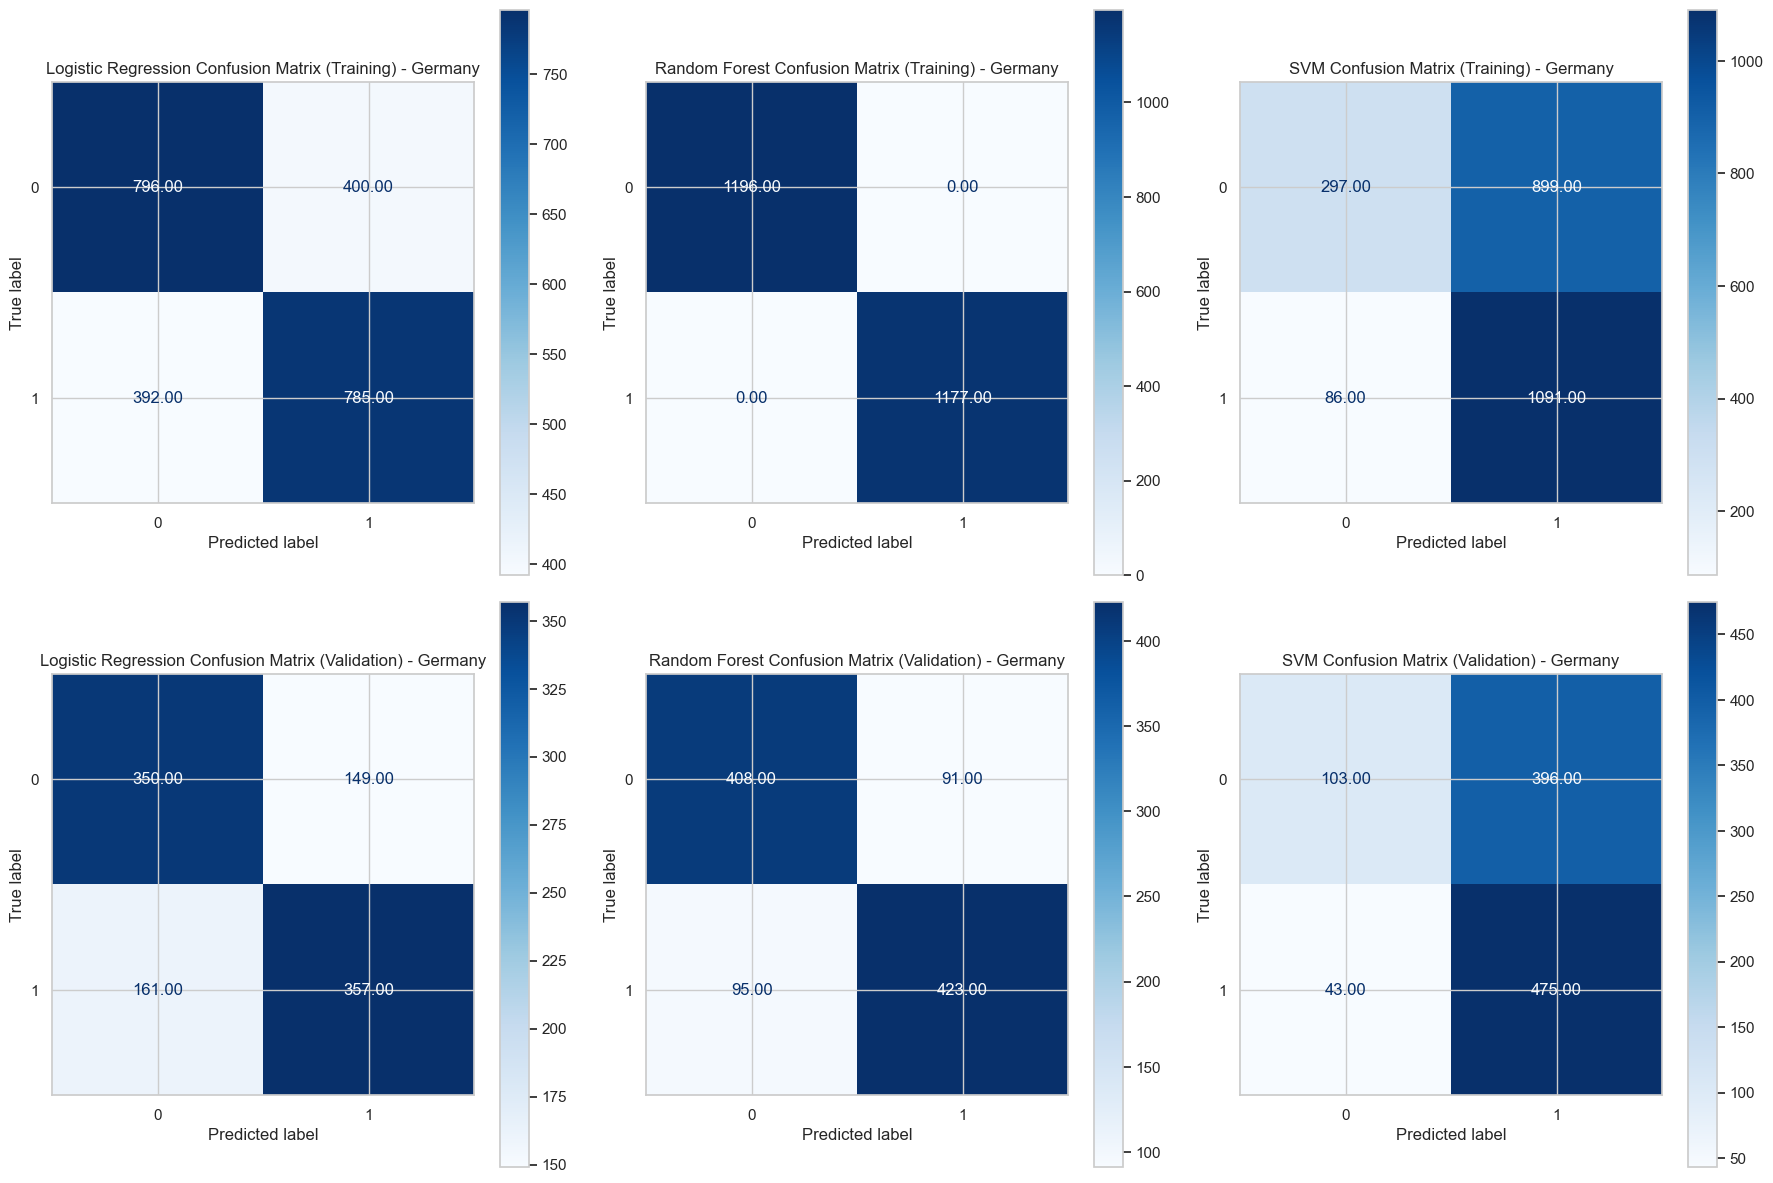

In [70]:
# Germany
X_train, X_test, y_train, y_test = train_test_split(X_germany_oversampled, y_germany_oversampled, test_size=0.3, random_state=42)

# Plot confusion matrices for all models on France dataset
plot_confusion_matrices_grid(models, model_names, X_train, X_test, y_train, y_test, "Germany")

#### Precision-Recall & ROC Curve - All Models

In [71]:
# Function to plot Precision-Recall and ROC curves for multiple models
def plot_all_models_curves(models, model_names, X_train, X_test, y_train, y_test, country_name):
    plt.figure(figsize=(12, 6))

    # Subplot 1: Precision-Recall Curve
    plt.subplot(1, 2, 1)

    for model, model_name in zip(models, model_names):
        # Train the model
        model.fit(X_train, y_train)

        # Get predicted probabilities for Precision-Recall curve
        y_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)

        # Plot Precision-Recall curve
        plt.plot(recall, precision, marker='.', label=f"{model_name}")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Precision-Recall Curve ({country_name})")
    plt.legend()

    # Subplot 2: ROC Curve
    plt.subplot(1, 2, 2)

    for model, model_name in zip(models, model_names):
        # Train the model
        model.fit(X_train, y_train)

        # Get predicted probabilities for ROC curve
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, marker='.', label=f"{model_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', label="Random Guessing")  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve ({country_name})")
    plt.legend()

    plt.tight_layout()
    plt.show()

# List of models
models = [
    LogisticRegression(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True)  # SVM with probability=True to get probabilities
]
model_names = ["Logistic Regression", "Random Forest", "SVM"]


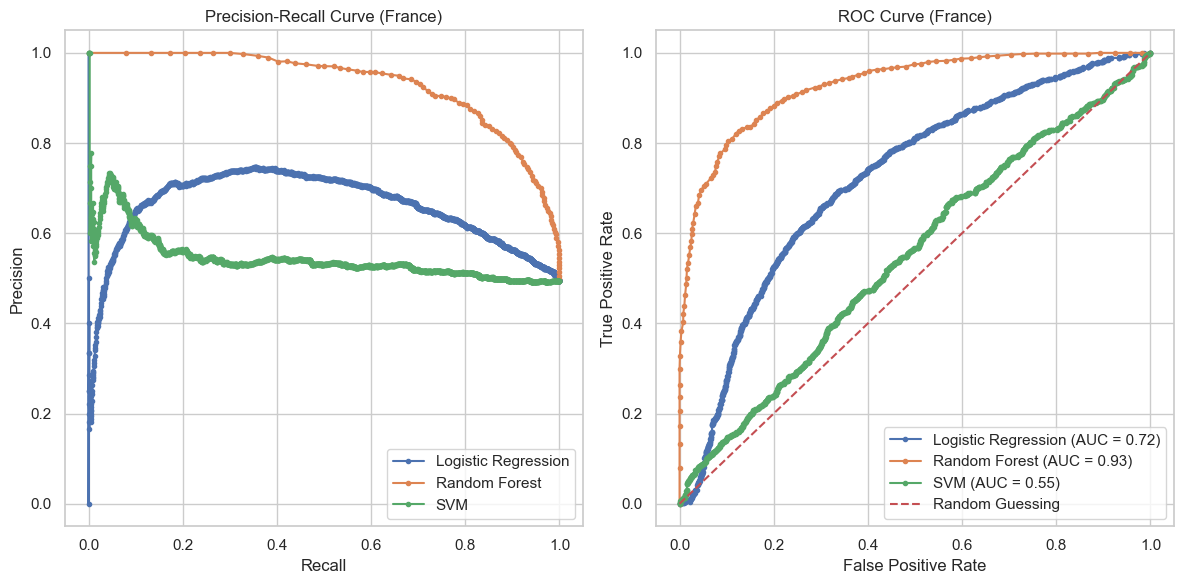

In [72]:
# France
X_train, X_test, y_train, y_test = train_test_split(X_france_oversampled, y_france_oversampled, test_size=0.3, random_state=42)

plot_all_models_curves(models, model_names, X_train, X_test, y_train, y_test, "France")

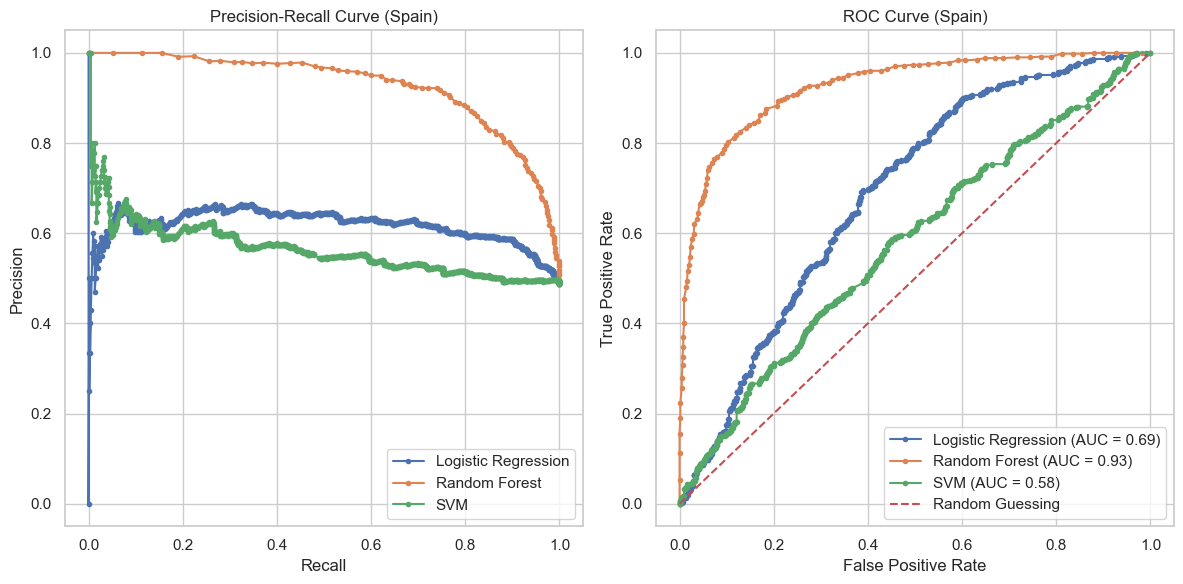

In [73]:
# Spain
X_train, X_test, y_train, y_test = train_test_split(X_spain_oversampled, y_spain_oversampled, test_size=0.3, random_state=42)

plot_all_models_curves(models, model_names, X_train, X_test, y_train, y_test, "Spain")

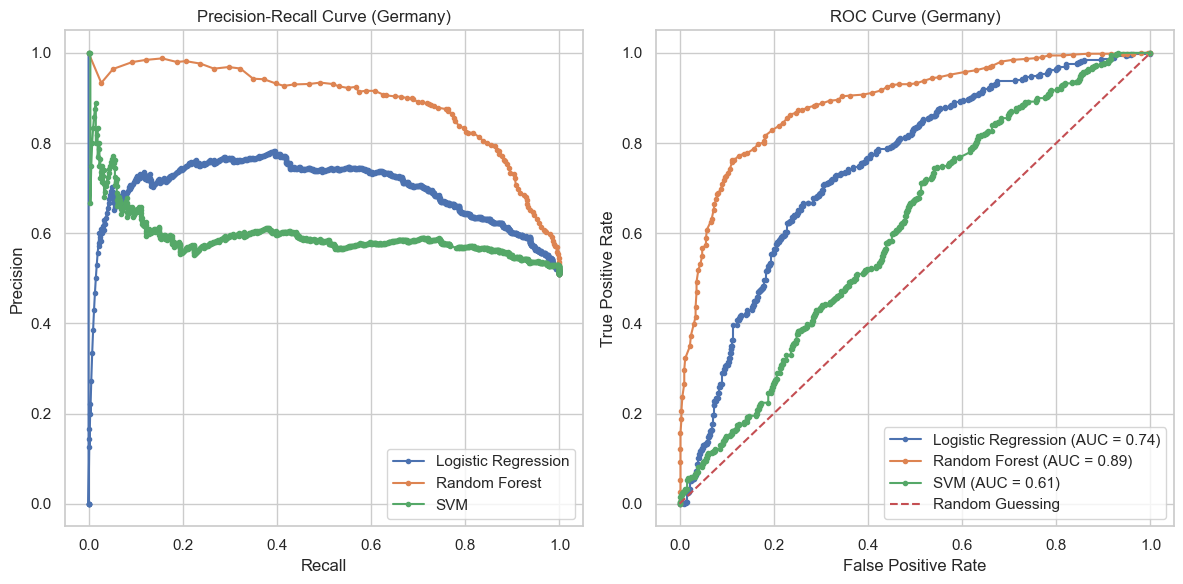

In [74]:
# Germany
X_train, X_test, y_train, y_test = train_test_split(X_germany_oversampled, y_germany_oversampled, test_size=0.3, random_state=42)

plot_all_models_curves(models, model_names, X_train, X_test, y_train, y_test, "Germany")

### Selected Model: Random Forest, Oversampled Dataset

#### Hyperparameter Tunning - France

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.3s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   4.1s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.7s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; to

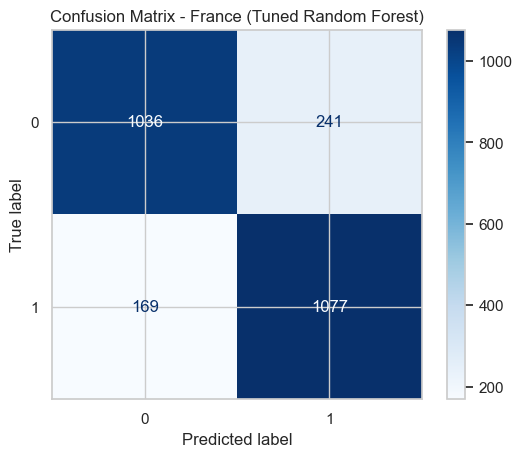

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.5s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.6s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=

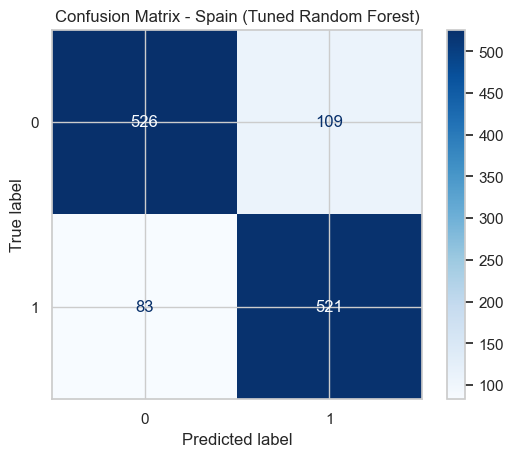

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   3.4s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators

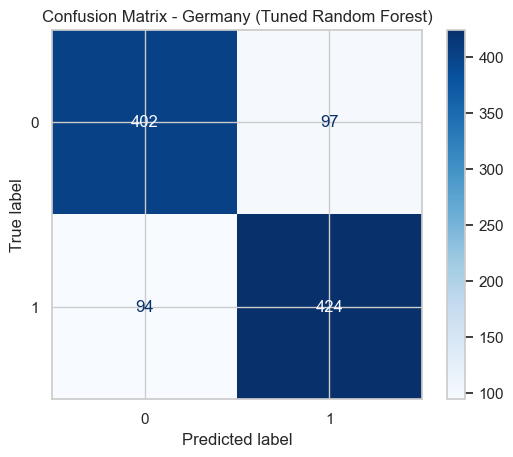

In [77]:
# Hyperparameter tunning with only the test data
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

def train_tuned_random_forest(X, y, country_name):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_model = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {country_name}: {grid_search.best_params_}")
    best_rf_model = grid_search.best_estimator_

    y_pred = best_rf_model.predict(X_test)

    print(f"Random Forest Results for {country_name}:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {country_name} (Tuned Random Forest)")
    plt.show()

train_tuned_random_forest(X_france_oversampled, y_france_oversampled, "France")

train_tuned_random_forest(X_spain_oversampled, y_spain_oversampled, "Spain")

train_tuned_random_forest(X_germany_oversampled, y_germany_oversampled, "Germany")

#### Cross Validation - Feature Importance Plotting

In [82]:
def cross_validate_tuned_random_forest(X, y, country_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_model = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {country_name}: {grid_search.best_params_}")
    best_rf_model = grid_search.best_estimator_

    cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"Cross-validation results for {country_name}:")
    print(f"Accuracy per fold: {cv_scores}")
    print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")

    y_test_pred = best_rf_model.predict(X_test)
    print(f"Test Accuracy for {country_name}: {best_rf_model.score(X_test, y_test):.4f}")

    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {country_name} (Test Data)")
    plt.show()

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimator

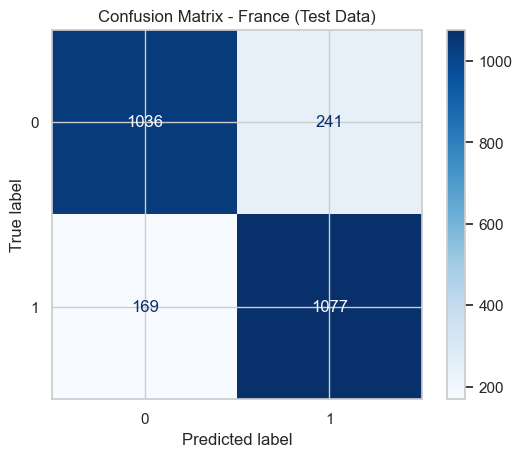

In [83]:
# Apply cross-validation for France
cross_validate_tuned_random_forest(X_france_oversampled, y_france_oversampled, "France")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.9s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators

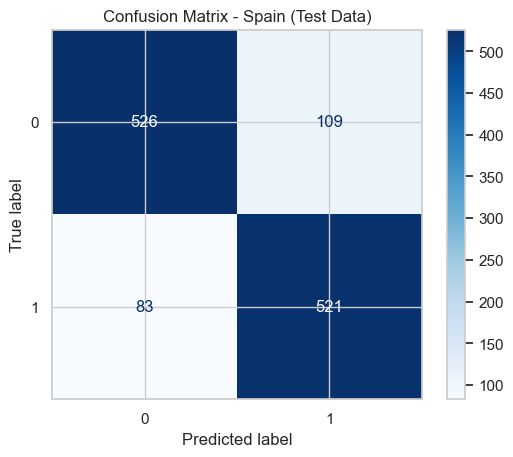

In [84]:
# Apply cross-validation for Spain
cross_validate_tuned_random_forest(X_spain_oversampled, y_spain_oversampled, "Spain")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

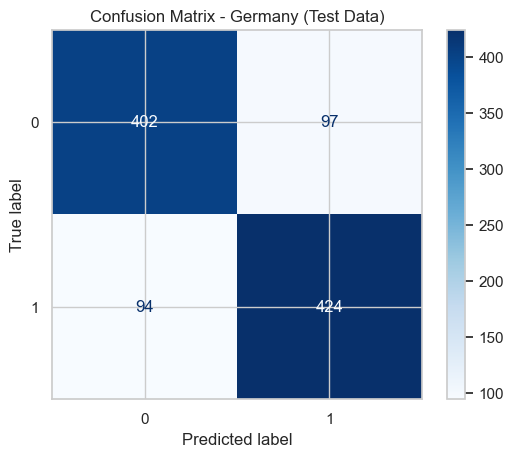

In [85]:
# Apply cross-validation for Germany
cross_validate_tuned_random_forest(X_germany_oversampled, y_germany_oversampled, "Germany")

#### Feature Importance

In [86]:
print(X_france.columns)
print(X_spain.columns)
print(X_germany.columns)

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'NumOfProducts_2',
       'NumOfProducts_3', 'NumOfProducts_4'],
      dtype='object')
Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'NumOfProducts_2',
       'NumOfProducts_3', 'NumOfProducts_4'],
      dtype='object')
Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'NumOfProducts_2',
       'NumOfProducts_3', 'NumOfProducts_4'],
      dtype='object')


In [87]:
feature_names = ['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard',
                 'IsActiveMember', 'EstimatedSalary', 'NumOfProducts_2',
                 'NumOfProducts_3', 'NumOfProducts_4']

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot feature importance
def plot_feature_importance(model, feature_names, country_name):
    """Plot the feature importance from a RandomForest model."""
    feature_importances = model.feature_importances_

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'Feature Importance for Random Forest - {country_name}')
    plt.tight_layout()
    plt.show()

# Modified function to include feature importance analysis using the tuned model from cross-validation
def cross_validate_and_feature_importance(X, y, country_name, feature_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # Hyperparameter grid (already defined in your code)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    # Fit the model using cross-validation
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV (tuned model)
    best_rf_model = grid_search.best_estimator_

    # Evaluate on the test set
    y_test_pred = best_rf_model.predict(X_test)
    print(f"Test accuracy for {country_name}: {best_rf_model.score(X_test, y_test):.4f}")

    # Plot the confusion matrix for test data
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {country_name} (Test Data)")
    plt.show()

    # Plot feature importance using the tuned model
    plot_feature_importance(best_rf_model, feature_names, country_name)



Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Test accuracy for France: 0.8375


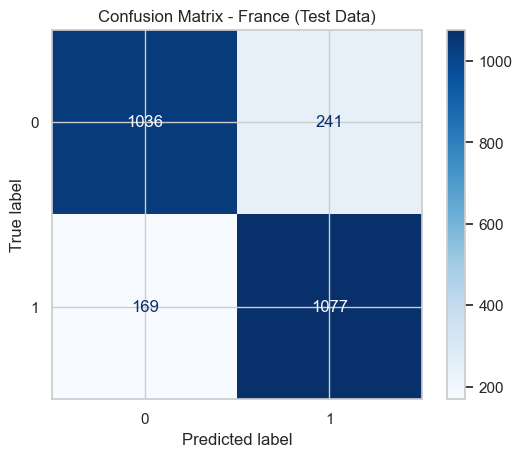

/var/folders/6b/pl83x5dn2wxf9xqt_8l7jqqm0000gn/T/ipykernel_90136/3278707842.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


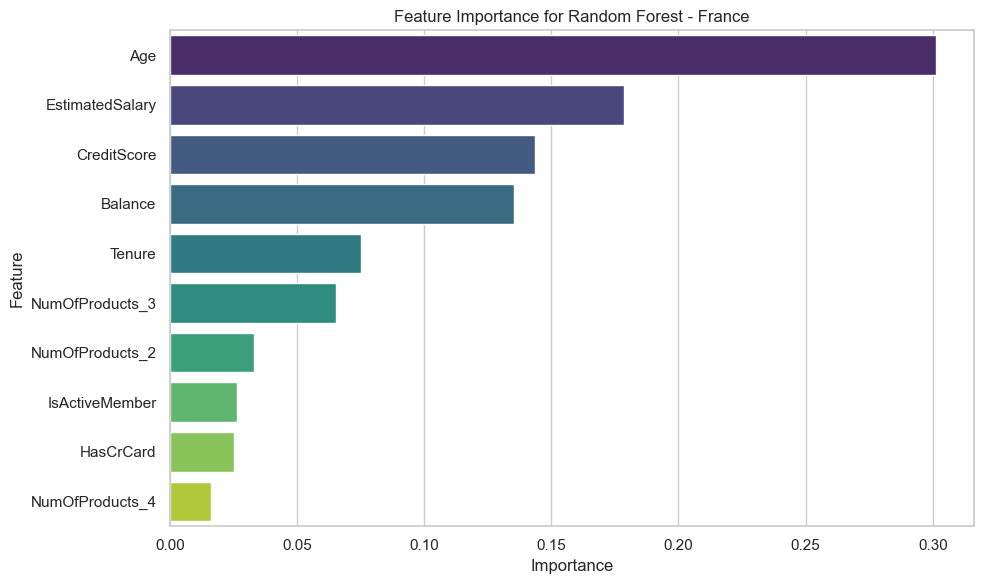

In [91]:
# France
cross_validate_and_feature_importance(X_france_oversampled, y_france_oversampled, "France", feature_names)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.5s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; 

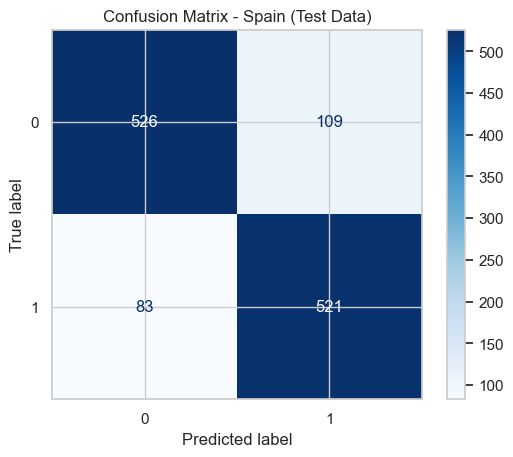

/var/folders/6b/pl83x5dn2wxf9xqt_8l7jqqm0000gn/T/ipykernel_90136/3278707842.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


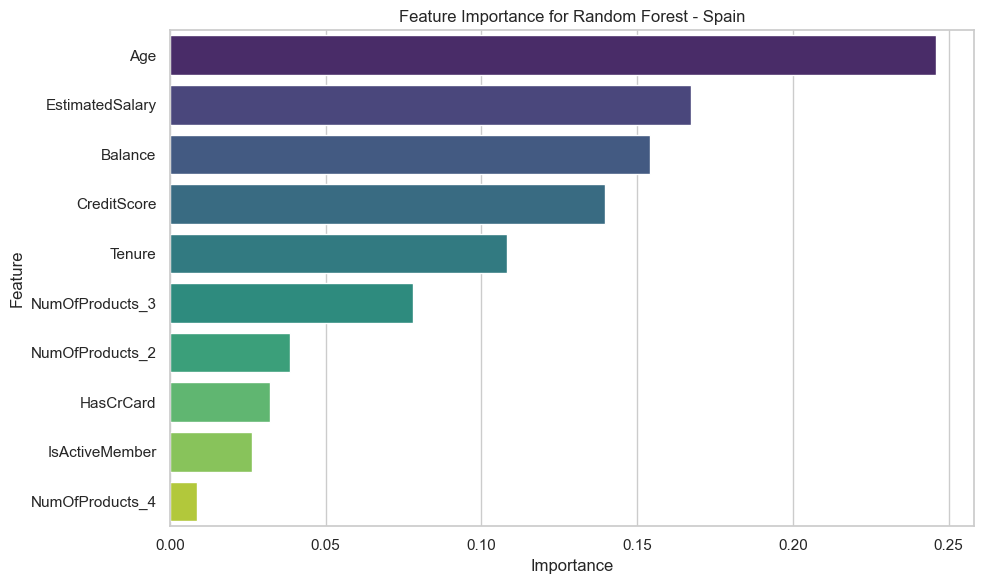

In [92]:
# Spain
cross_validate_and_feature_importance(X_spain_oversampled, y_spain_oversampled, "Spain", feature_names)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; 

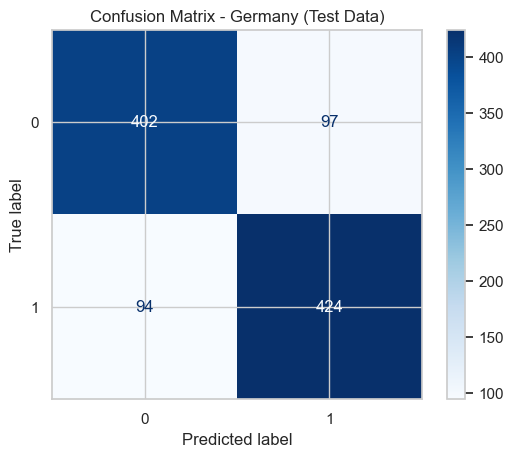

/var/folders/6b/pl83x5dn2wxf9xqt_8l7jqqm0000gn/T/ipykernel_90136/3278707842.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


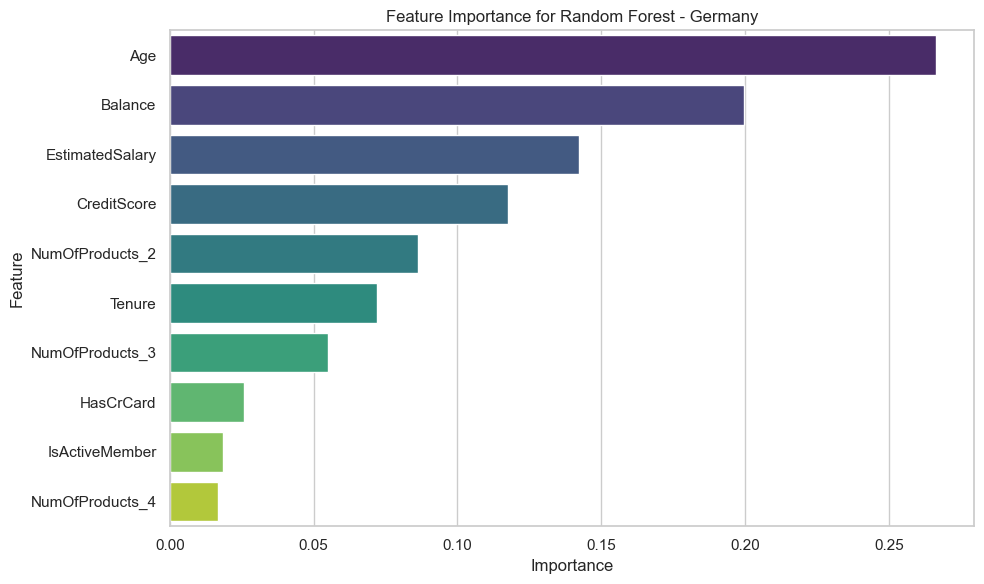

In [93]:
# Germany
cross_validate_and_feature_importance(X_germany_oversampled, y_germany_oversampled, "Germany", feature_names)

In [ ]:
# List of columns to drop
columns_to_drop = ['Surname', 'Gender', 'CustomerId']

df_cleaned = df_bank_churn.drop(columns=columns_to_drop)

df_cleaned.head()

#### Categorical Feature Summary

Here we assess the distribution of values across categorical features 

In [ ]:
# Set the count to distinct values in each categorical feature
for col_name in ['Geography', 'NumOfProducts']:
    print(f"\nDistinct counts for {col_name}:")
    print(df_cleaned[col_name].value_counts())


In [ ]:
sns.set(style="whitegrid")

# Create two subplots - one for 'Geography' and one for 'NumOfProducts'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution of 'Geography'
sns.countplot(ax=axes[0], data=df_bank_churn, x='Geography', hue='Geography', palette='Set2', legend=False)
axes[0].set_title('Distribution of Geography')
axes[0].set_xlabel('Geography')
axes[0].set_ylabel('Count')

# Plot the distribution of 'NumOfProducts'
sns.countplot(ax=axes[1], data=df_bank_churn, x='NumOfProducts', hue='NumOfProducts', palette='Set2', legend=False)
axes[1].set_title('Distribution of NumOfProducts')
axes[1].set_xlabel('Number of Products')
axes[1].set_ylabel('Count')

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()

#### Class Imbalance Analysis

Here we determine the distribution of the target feature "Exited" where we want to assess class imbalance that is a critical factor to implement Machine Learning Models

In [ ]:
# Count the number of occurrences for each class in 'Late_delivery_risk'
exited_counts = df_cleaned['Exited'].value_counts()

# Display the counts
print("Count of occurrences for each class in 'Exited':")
print(exited_counts)

#### Region Specific Churn Analysis

If we train one global model it might not capture the unique patterns in each country. Training separate models for France, Spain and Germany would likely improve the accuracy of the predictions and allow us to identify features that are most important in each region.

In [ ]:
# Split the dataset by country
df_france = df_cleaned[df_bank_churn['Geography'] == 'France']
df_spain = df_cleaned[df_bank_churn['Geography'] == 'Spain']
df_germany = df_cleaned[df_bank_churn['Geography'] == 'Germany']

# Verify the split
print("France dataset size:", df_france.shape)
print("Spain dataset size:", df_spain.shape)
print("Germany dataset size:", df_germany.shape)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set(style="whitegrid")

# Create a figure with 3 subplots (one for each country)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# France
sns.countplot(ax=axes[0], data=df_france, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[0].set_title('Churn Distribution in France')
axes[0].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[0].set_ylabel('Count')

# Spain
sns.countplot(ax=axes[1], data=df_spain, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[1].set_title('Churn Distribution in Spain')
axes[1].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[1].set_ylabel('Count')

# Germany
sns.countplot(ax=axes[2], data=df_germany, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[2].set_title('Churn Distribution in Germany')
axes[2].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Function to normalize churn
def normalize_churn(df):
    churn_counts = df['Exited'].value_counts(normalize=True) * 100
    return churn_counts

# Normalize churn for each country
churn_france = normalize_churn(df_france)
churn_spain = normalize_churn(df_spain)
churn_germany = normalize_churn(df_germany)

# Plot the normalized churn distribution for each country
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for France
sns.barplot(x=churn_france.index, y=churn_france.values, ax=axes[0], hue=churn_france.index, palette='Set2', legend=False)
axes[0].set_title('Normalized Churn Distribution in France')
axes[0].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[0].set_ylabel('Percentage')

# Plot for Spain
sns.barplot(x=churn_spain.index, y=churn_spain.values, ax=axes[1], hue=churn_spain.index, palette='Set2', legend=False)
axes[1].set_title('Normalized Churn Distribution in Spain')
axes[1].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[1].set_ylabel('Percentage')

# Plot for Germany
sns.barplot(x=churn_germany.index, y=churn_germany.values, ax=axes[2], hue=churn_germany.index, palette='Set2', legend=False)
axes[2].set_title('Normalized Churn Distribution in Germany')
axes[2].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[2].set_ylabel('Percentage')

# Adjust layout
plt.tight_layout()
plt.show()

#### Feature Selection
The dataset is conformed by 10 features after dropping the ones that could affect the analysis or that are not most relevant

In [ ]:
print(df_cleaned.columns)

In [ ]:
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# Define target (Exited)
target = 'Exited'

# Select features and target for France
X_france = df_france[features]
y_france = df_france[target]

# Select features and target for Spain
X_spain = df_spain[features]
y_spain = df_spain[target]

# Select features and target for Germany
X_germany = df_germany[features]
y_germany = df_germany[target]

# Verify the shape of the selected data
print("France selected data shape:", X_france.shape)
print("Spain selected data shape:", X_spain.shape)
print("Germany selected data shape:", X_germany.shape)

#### One Hot Encoding

In [ ]:
# One-hot encode the 'NumOfProducts' column
X_france = pd.get_dummies(df_france[features], columns=['NumOfProducts'], drop_first=True)
X_spain = pd.get_dummies(df_spain[features], columns=['NumOfProducts'], drop_first=True)
X_germany = pd.get_dummies(df_germany[features], columns=['NumOfProducts'], drop_first=True)

# The target remains the same
y_france = df_france[target]
y_spain = df_spain[target]
y_germany = df_germany[target]

# Verify the shape of the selected data after one-hot encoding
print("France selected data shape after encoding:", X_france.shape)
print("Spain selected data shape after encoding:", X_spain.shape)
print("Germany selected data shape after encoding:", X_germany.shape)

### Modelling
Here we select the Random Forest, SVM, and Logistic Regression to make the analysis

### Undersampled Dataset

In [ ]:
# Function to perform undersampling
def undersample_data(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled
 
# France dataset
X_france_resampled, y_france_resampled = undersample_data(X_france, y_france)
print("France data shape after undersampling:", X_france_resampled.shape)
print("France target shape after undersampling:", y_france_resampled.shape)

# Spain dataset
X_spain_resampled, y_spain_resampled = undersample_data(X_spain, y_spain)
print("Spain data shape after undersampling:", X_spain_resampled.shape)
print("Spain target shape after undersampling:", y_spain_resampled.shape)

# Germany dataset
X_germany_resampled, y_germany_resampled = undersample_data(X_germany, y_germany)
print("Germany data shape after undersampling:", X_germany_resampled.shape)
print("Germany target shape after undersampling:", y_germany_resampled.shape)

In [ ]:
# Function to plot the distribution of the 'Exited' feature
def plot_exited_distribution(y_resampled, title):
    sns.countplot(x=y_resampled, palette='Set2', hue=y_resampled, legend=False)
    plt.title(title)
    plt.xlabel('Exited (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.show()

# Plot for France after undersampling
plot_exited_distribution(y_france_resampled, "Exited Distribution After Undersampling (France)")

# Plot for Spain after undersampling
plot_exited_distribution(y_spain_resampled, "Exited Distribution After Undersampling (Spain)")

# Plot for Germany after undersampling
plot_exited_distribution(y_germany_resampled, "Exited Distribution After Undersampling (Germany)")

#### Logistic Regression

In [ ]:
%%time
# Function to train Logistic Regression and evaluate performance
def train_logistic_regression(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Logistic Regression model
    lr_model = LogisticRegression(random_state=42)

    # Train the model
    lr_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lr_model.predict(X_test)

    # Print classification report
    print(f"Logistic Regression Results for {country_name}:")
    print(classification_report(y_test, y_pred))

# Train and evaluate Logistic Regression for France
train_logistic_regression(X_france_resampled, y_france_resampled, "France")

# Train and evaluate Logistic Regression for Spain
train_logistic_regression(X_spain_resampled, y_spain_resampled, "Spain")

# Train and evaluate Logistic Regression for Germany
train_logistic_regression(X_germany_resampled, y_germany_resampled, "Germany")

#### Random Forest

In [ ]:
%%time
# Function to train Random Forest and evaluate performance
def train_random_forest(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    # Print classification report
    print(f"Random Forest Results for {country_name}:")
    print(classification_report(y_test, y_pred))

# Train and evaluate Random Forest for France
train_random_forest(X_france_resampled, y_france_resampled, "France")

# Train and evaluate Random Forest for Spain
train_random_forest(X_spain_resampled, y_spain_resampled, "Spain")

# Train and evaluate Random Forest for Germany
train_random_forest(X_germany_resampled, y_germany_resampled, "Germany")

#### SVM

In [ ]:
%%time
# Function to train SVM and evaluate performance
def train_svm(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the SVM model
    svm_model = SVC(random_state=42)

    # Train the model
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Print classification report
    print(f"SVM Results for {country_name}:")
    print(classification_report(y_test, y_pred))

# Train and evaluate SVM for France
train_svm(X_france_resampled, y_france_resampled, "France")

# Train and evaluate SVM for Spain
train_svm(X_spain_resampled, y_spain_resampled, "Spain")

# Train and evaluate SVM for Germany
train_svm(X_germany_resampled, y_germany_resampled, "Germany")

#### Confusion Matrix

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Function to train a model and plot confusion matrices
def train_and_plot_confusion_matrices(model, X_train, X_test, y_train, y_test, model_name, country_name):
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on training data
    y_train_pred = model.predict(X_train)
    plot_confusion_matrix(y_train, y_train_pred, f"{model_name} Confusion Matrix (Training) - {country_name}")

    # Predictions on validation (test) data
    y_test_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_test_pred, f"{model_name} Confusion Matrix (Validation) - {country_name}")

# You can repeat this process for Logistic Regression and Random Forest for each country

#### France

In [ ]:
svm_model = SVC(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_france_resampled, y_france_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(svm_model, X_train, X_test, y_train, y_test, "SVM", "France")

In [ ]:
lr_model = LogisticRegression(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_france_resampled, y_france_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(lr_model, X_train, X_test, y_train, y_test, "Logistic Regression", "France")

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_france_resampled, y_france_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(rf_model, X_train, X_test, y_train, y_test, "Random Forest", "France")

### Spain

In [ ]:
svm_model = SVC(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_spain_resampled, y_spain_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(svm_model, X_train, X_test, y_train, y_test, "SVM", "Spain")

In [ ]:
# Common Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_precision_recall_curve, plot_roc_curve

# Modelling
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Testing and Evaluation
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
import unittest

In [ ]:
file_path = '../src/Bank+Customer+Churn/Bank_Churn.csv'

# Load the CSV file into a DataFrame, handling potential errors
try:
    # Load the CSV with specified encoding and handle any bad lines
    df_bank_churn = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')
    print("Data loaded successfully. Displaying the first 5 rows:")
    print(df_bank_churn.head())

    # Print the column names
    print("\nColumn names:")
    print(df_bank_churn.columns)

except FileNotFoundError:
    print("Error: File not found at the specified path.")
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file. Please check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

## Exploratory Data Analysis

#### Volume of Data

In [ ]:
# Count the number of records (rows) and features (columns)
num_records = len(df_bank_churn)
num_features = len(df_bank_churn.columns)

# Print the size of the dataset
print(f"The dataset has {num_records} records and {num_features} features.")

In [ ]:
# Basic data exploration
print("Shape of the dataset:", df_bank_churn.shape)
print("Data types:", df_bank_churn.dtypes)
print("Missing values in each column:", df_bank_churn.isnull().sum())
df_bank_churn.describe()

#### Data Cleaning

##### Fixing Data Types

In [ ]:
# Change the data types of the specified columns to Boolean because of the description of each
df_bank_churn['HasCrCard'] = df_bank_churn['HasCrCard'].astype(bool)
df_bank_churn['IsActiveMember'] = df_bank_churn['IsActiveMember'].astype(bool)

print(df_bank_churn[['HasCrCard', 'IsActiveMember']].dtypes)

In [ ]:
# List of columns to drop
columns_to_drop = ['Surname', 'Gender', 'CustomerId']

df_cleaned = df_bank_churn.drop(columns=columns_to_drop)

df_cleaned.head()

#### Categorical Feature Summary

Here we assess the distribution of values across categorical features 

In [ ]:
# Set the count to distinct values in each categorical feature
for col_name in ['Geography', 'NumOfProducts']:
    print(f"\nDistinct counts for {col_name}:")
    print(df_cleaned[col_name].value_counts())


In [ ]:
sns.set(style="whitegrid")

# Create two subplots - one for 'Geography' and one for 'NumOfProducts'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution of 'Geography'
sns.countplot(ax=axes[0], data=df_bank_churn, x='Geography', hue='Geography', palette='Set2', legend=False)
axes[0].set_title('Distribution of Geography')
axes[0].set_xlabel('Geography')
axes[0].set_ylabel('Count')

# Plot the distribution of 'NumOfProducts'
sns.countplot(ax=axes[1], data=df_bank_churn, x='NumOfProducts', hue='NumOfProducts', palette='Set2', legend=False)
axes[1].set_title('Distribution of NumOfProducts')
axes[1].set_xlabel('Number of Products')
axes[1].set_ylabel('Count')

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()

#### Class Imbalance Analysis

Here we determine the distribution of the target feature "Exited" where we want to assess class imbalance that is a critical factor to implement Machine Learning Models

In [ ]:
# Count the number of occurrences for each class in 'Late_delivery_risk'
exited_counts = df_cleaned['Exited'].value_counts()

# Display the counts
print("Count of occurrences for each class in 'Exited':")
print(exited_counts)

#### Region Specific Churn Analysis

If we train one global model it might not capture the unique patterns in each country. Training separate models for France, Spain and Germany would likely improve the accuracy of the predictions and allow us to identify features that are most important in each region.

In [ ]:
# Split the dataset by country
df_france = df_cleaned[df_bank_churn['Geography'] == 'France']
df_spain = df_cleaned[df_bank_churn['Geography'] == 'Spain']
df_germany = df_cleaned[df_bank_churn['Geography'] == 'Germany']

# Verify the split
print("France dataset size:", df_france.shape)
print("Spain dataset size:", df_spain.shape)
print("Germany dataset size:", df_germany.shape)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set(style="whitegrid")

# Create a figure with 3 subplots (one for each country)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# France
sns.countplot(ax=axes[0], data=df_france, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[0].set_title('Churn Distribution in France')
axes[0].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[0].set_ylabel('Count')

# Spain
sns.countplot(ax=axes[1], data=df_spain, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[1].set_title('Churn Distribution in Spain')
axes[1].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[1].set_ylabel('Count')

# Germany
sns.countplot(ax=axes[2], data=df_germany, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[2].set_title('Churn Distribution in Germany')
axes[2].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Function to normalize churn
def normalize_churn(df):
    churn_counts = df['Exited'].value_counts(normalize=True) * 100
    return churn_counts

# Normalize churn for each country
churn_france = normalize_churn(df_france)
churn_spain = normalize_churn(df_spain)
churn_germany = normalize_churn(df_germany)

# Plot the normalized churn distribution for each country
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for France
sns.barplot(x=churn_france.index, y=churn_france.values, ax=axes[0], hue=churn_france.index, palette='Set2', legend=False)
axes[0].set_title('Normalized Churn Distribution in France')
axes[0].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[0].set_ylabel('Percentage')

# Plot for Spain
sns.barplot(x=churn_spain.index, y=churn_spain.values, ax=axes[1], hue=churn_spain.index, palette='Set2', legend=False)
axes[1].set_title('Normalized Churn Distribution in Spain')
axes[1].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[1].set_ylabel('Percentage')

# Plot for Germany
sns.barplot(x=churn_germany.index, y=churn_germany.values, ax=axes[2], hue=churn_germany.index, palette='Set2', legend=False)
axes[2].set_title('Normalized Churn Distribution in Germany')
axes[2].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[2].set_ylabel('Percentage')

# Adjust layout
plt.tight_layout()
plt.show()

#### Feature Selection
The dataset is conformed by 10 features after dropping the ones that could affect the analysis or that are not most relevant

In [ ]:
print(df_cleaned.columns)

In [ ]:
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# Define target (Exited)
target = 'Exited'

# Select features and target for France
X_france = df_france[features]
y_france = df_france[target]

# Select features and target for Spain
X_spain = df_spain[features]
y_spain = df_spain[target]

# Select features and target for Germany
X_germany = df_germany[features]
y_germany = df_germany[target]

# Verify the shape of the selected data
print("France selected data shape:", X_france.shape)
print("Spain selected data shape:", X_spain.shape)
print("Germany selected data shape:", X_germany.shape)

#### One Hot Encoding

In [ ]:
# One-hot encode the 'NumOfProducts' column
X_france = pd.get_dummies(df_france[features], columns=['NumOfProducts'], drop_first=True)
X_spain = pd.get_dummies(df_spain[features], columns=['NumOfProducts'], drop_first=True)
X_germany = pd.get_dummies(df_germany[features], columns=['NumOfProducts'], drop_first=True)

# The target remains the same
y_france = df_france[target]
y_spain = df_spain[target]
y_germany = df_germany[target]

# Verify the shape of the selected data after one-hot encoding
print("France selected data shape after encoding:", X_france.shape)
print("Spain selected data shape after encoding:", X_spain.shape)
print("Germany selected data shape after encoding:", X_germany.shape)

### Modelling
Here we select the Random Forest, SVM, and Logistic Regression to make the analysis

### Undersampled Dataset

In [ ]:
# Function to perform undersampling
def undersample_data(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled
 
# France dataset
X_france_resampled, y_france_resampled = undersample_data(X_france, y_france)
print("France data shape after undersampling:", X_france_resampled.shape)
print("France target shape after undersampling:", y_france_resampled.shape)

# Spain dataset
X_spain_resampled, y_spain_resampled = undersample_data(X_spain, y_spain)
print("Spain data shape after undersampling:", X_spain_resampled.shape)
print("Spain target shape after undersampling:", y_spain_resampled.shape)

# Germany dataset
X_germany_resampled, y_germany_resampled = undersample_data(X_germany, y_germany)
print("Germany data shape after undersampling:", X_germany_resampled.shape)
print("Germany target shape after undersampling:", y_germany_resampled.shape)

In [ ]:
# Function to plot the distribution of the 'Exited' feature
def plot_exited_distribution(y_resampled, title):
    sns.countplot(x=y_resampled, palette='Set2', hue=y_resampled, legend=False)
    plt.title(title)
    plt.xlabel('Exited (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.show()

# Plot for France after undersampling
plot_exited_distribution(y_france_resampled, "Exited Distribution After Undersampling (France)")

# Plot for Spain after undersampling
plot_exited_distribution(y_spain_resampled, "Exited Distribution After Undersampling (Spain)")

# Plot for Germany after undersampling
plot_exited_distribution(y_germany_resampled, "Exited Distribution After Undersampling (Germany)")

#### Logistic Regression

In [ ]:
%%time
# Function to train Logistic Regression and evaluate performance
def train_logistic_regression(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Logistic Regression model
    lr_model = LogisticRegression(random_state=42)

    # Train the model
    lr_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lr_model.predict(X_test)

    # Print classification report
    print(f"Logistic Regression Results for {country_name}:")
    print(classification_report(y_test, y_pred))

# Train and evaluate Logistic Regression for France
train_logistic_regression(X_france_resampled, y_france_resampled, "France")

# Train and evaluate Logistic Regression for Spain
train_logistic_regression(X_spain_resampled, y_spain_resampled, "Spain")

# Train and evaluate Logistic Regression for Germany
train_logistic_regression(X_germany_resampled, y_germany_resampled, "Germany")

#### Random Forest

In [ ]:
%%time
# Function to train Random Forest and evaluate performance
def train_random_forest(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    # Print classification report
    print(f"Random Forest Results for {country_name}:")
    print(classification_report(y_test, y_pred))

# Train and evaluate Random Forest for France
train_random_forest(X_france_resampled, y_france_resampled, "France")

# Train and evaluate Random Forest for Spain
train_random_forest(X_spain_resampled, y_spain_resampled, "Spain")

# Train and evaluate Random Forest for Germany
train_random_forest(X_germany_resampled, y_germany_resampled, "Germany")

#### SVM

In [ ]:
%%time
# Function to train SVM and evaluate performance
def train_svm(X, y, country_name):
    # Split the resampled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the SVM model
    svm_model = SVC(random_state=42)

    # Train the model
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Print classification report
    print(f"SVM Results for {country_name}:")
    print(classification_report(y_test, y_pred))

# Train and evaluate SVM for France
train_svm(X_france_resampled, y_france_resampled, "France")

# Train and evaluate SVM for Spain
train_svm(X_spain_resampled, y_spain_resampled, "Spain")

# Train and evaluate SVM for Germany
train_svm(X_germany_resampled, y_germany_resampled, "Germany")

#### Confusion Matrix

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Function to train a model and plot confusion matrices
def train_and_plot_confusion_matrices(model, X_train, X_test, y_train, y_test, model_name, country_name):
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on training data
    y_train_pred = model.predict(X_train)
    plot_confusion_matrix(y_train, y_train_pred, f"{model_name} Confusion Matrix (Training) - {country_name}")

    # Predictions on validation (test) data
    y_test_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_test_pred, f"{model_name} Confusion Matrix (Validation) - {country_name}")

# You can repeat this process for Logistic Regression and Random Forest for each country

#### France

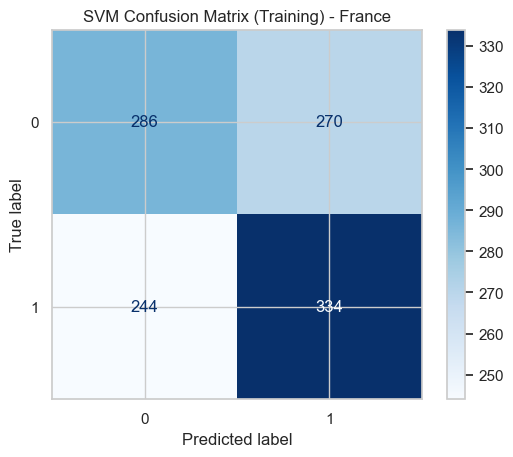

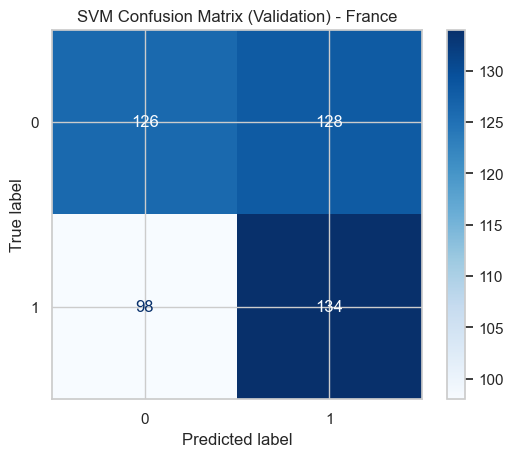

In [28]:
svm_model = SVC(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_france_resampled, y_france_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(svm_model, X_train, X_test, y_train, y_test, "SVM", "France")

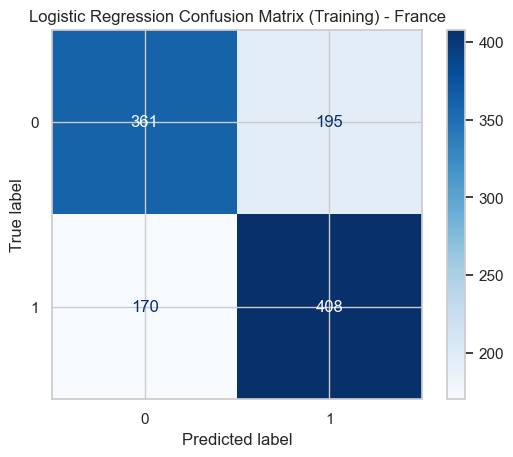

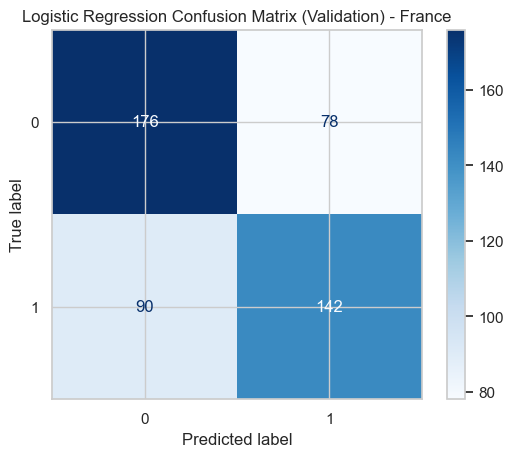

In [29]:
lr_model = LogisticRegression(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_france_resampled, y_france_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(lr_model, X_train, X_test, y_train, y_test, "Logistic Regression", "France")

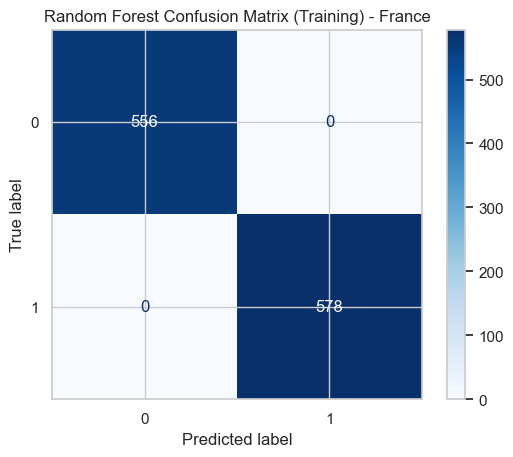

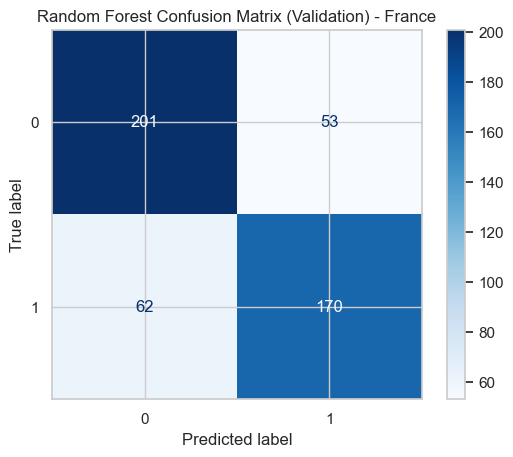

In [30]:
rf_model = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_france_resampled, y_france_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(rf_model, X_train, X_test, y_train, y_test, "Random Forest", "France")

### Spain

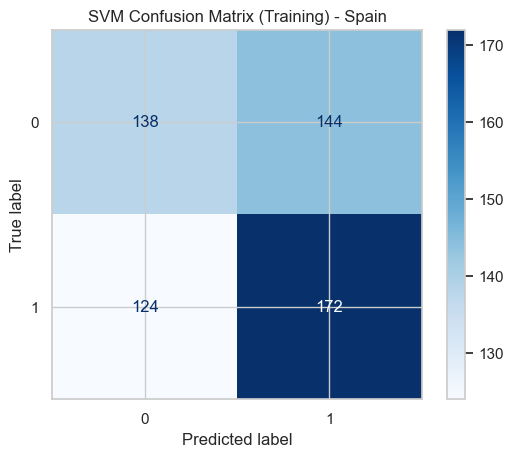

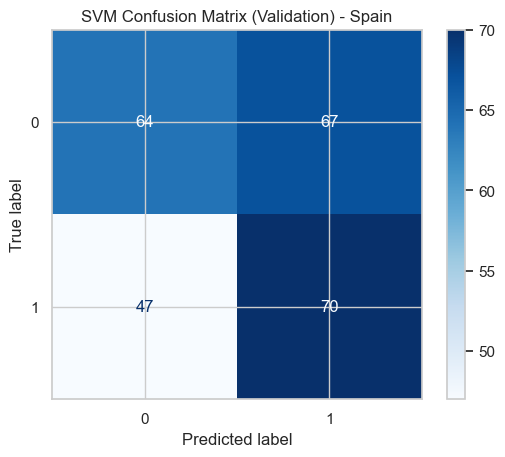

In [34]:
svm_model = SVC(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_spain_resampled, y_spain_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(svm_model, X_train, X_test, y_train, y_test, "SVM", "Spain")

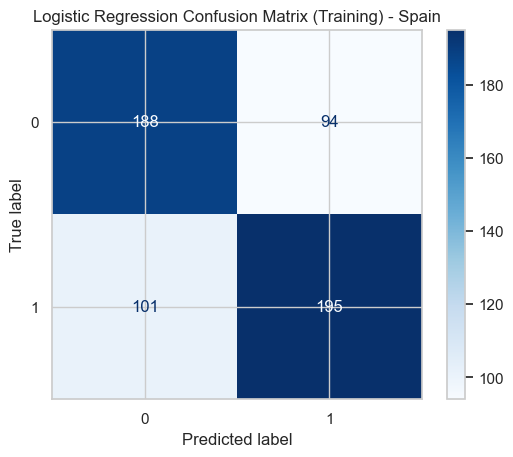

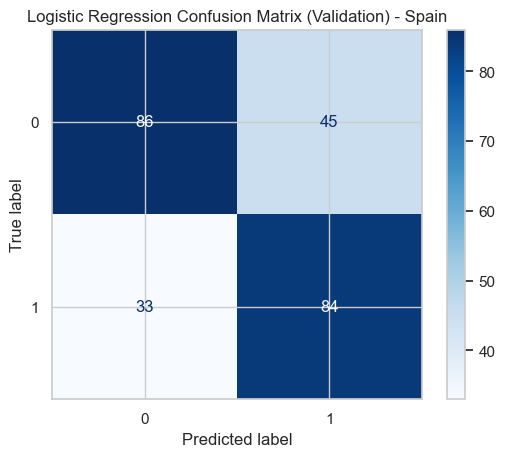

In [36]:
lr_model = LogisticRegression(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_spain_resampled, y_spain_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(lr_model, X_train, X_test, y_train, y_test, "Logistic Regression", "Spain")

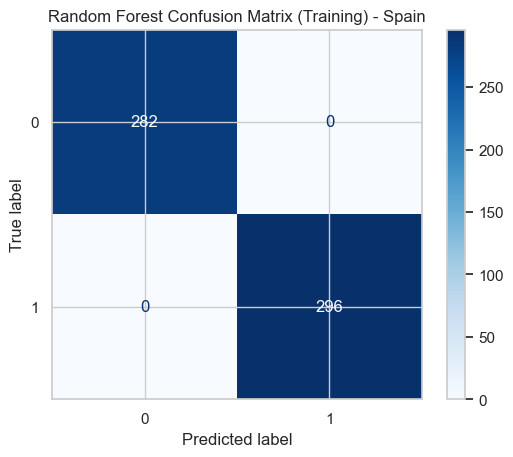

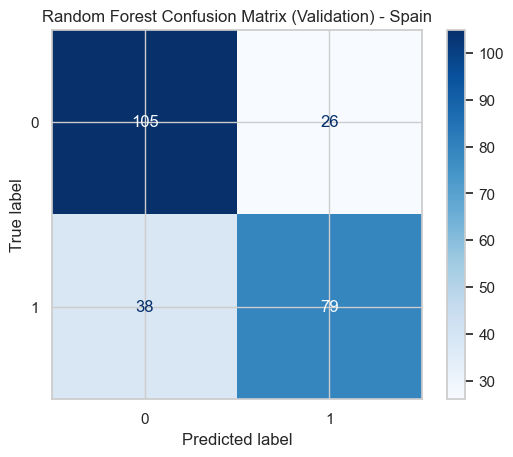

In [37]:
rf_model = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_spain_resampled, y_spain_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(rf_model, X_train, X_test, y_train, y_test, "Random Forest", "Spain")

#### Germany

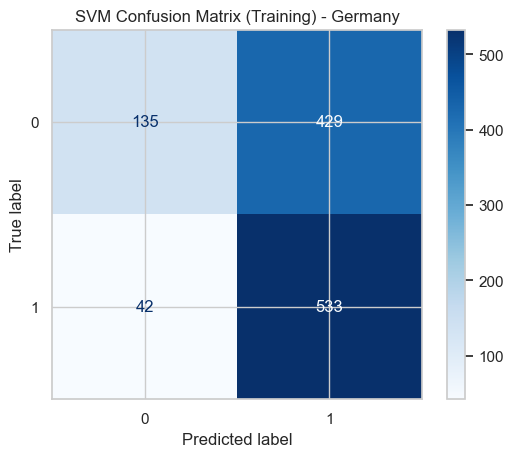

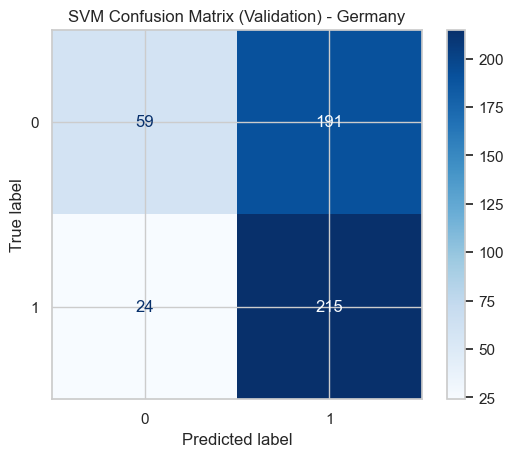

In [38]:
svm_model = SVC(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_germany_resampled, y_germany_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(svm_model, X_train, X_test, y_train, y_test, "SVM", "Germany")

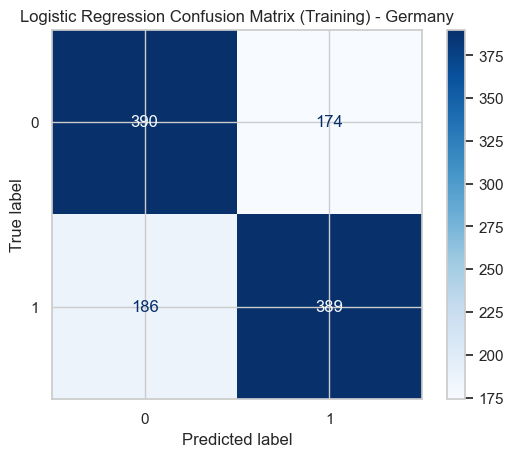

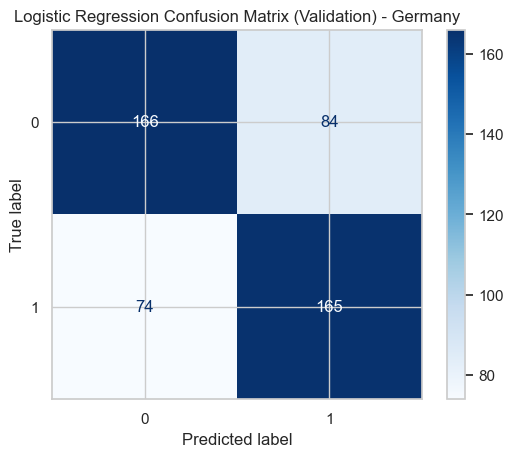

In [39]:
lr_model = LogisticRegression(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_germany_resampled, y_germany_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(lr_model, X_train, X_test, y_train, y_test, "Logistic Regression", "Germany")

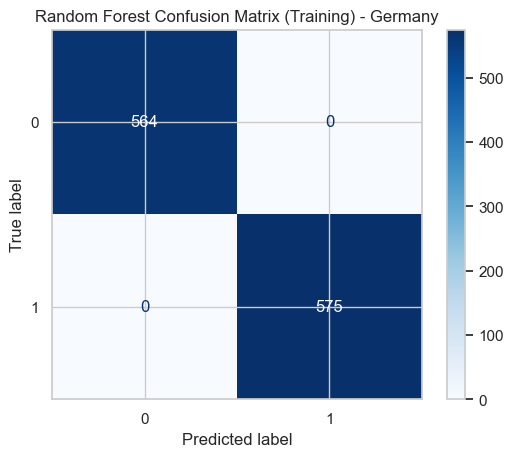

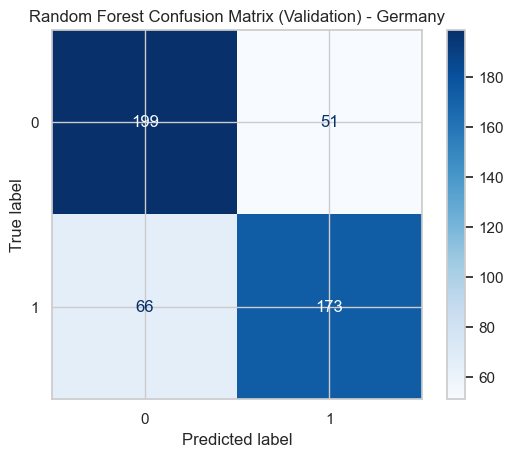

In [40]:
rf_model = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_germany_resampled, y_germany_resampled, test_size=0.3, random_state=42)
train_and_plot_confusion_matrices(rf_model, X_train, X_test, y_train, y_test, "Random Forest", "Germany")

In [41]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
import matplotlib.pyplot as plt

# Function to plot both Precision-Recall and ROC curves
def plot_evaluation_curves(model, X_train, X_test, y_train, y_test, model_name, country_name):
    # Train the model
    model.fit(X_train, y_train)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plot_precision_recall_curve(model, X_test, y_test)
    plt.title(f"Precision-Recall Curve ({model_name} - {country_name})")

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    plot_roc_curve(model, X_test, y_test)
    plt.title(f"ROC Curve ({model_name} - {country_name})")

    plt.tight_layout()
    plt.show()

# Example for Random Forest on France dataset
rf_model = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_france_resampled, y_france_resampled, test_size=0.3, random_state=42)

# Plot both evaluation curves
plot_evaluation_curves(rf_model, X_train, X_test, y_train, y_test, "Random Forest", "France")

ImportError: cannot import name 'plot_precision_recall_curve' from 'sklearn.metrics' (/opt/miniconda3/envs/untitled/lib/python3.8/site-packages/sklearn/metrics/__init__.py)